In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def RF_complete(data_t: "df", data_s_list: "list(df)", feature_t, n_tree=50, n_feature=5, f_sample=0.3, n_best_tree=5):
    '''
    TODO:
    - data_s_list might be a list of dataframes... Not just a list corresponding to one thing
    '''
    K = len(data_s_list) # Number of datasets given for training
    print(f"{K} additional datasets used for prediction.")

    if feature_t not in data_t.columns:
        print("Feature-of-interest not found in data_t! Please check column names of input data.")
        return None
    else:
        print("Feature-of-interest located!")

    mu = []
    sigma = []

    for k in range(0, K): # Iteratingg over data_s_list
        data_assist = data_s_list[k] #.iloc[k-1] # Indexing is in terms of rows
        # Locate feature of interest in training dataset k of K
        if feature_t in data_assist.columns:
            f_t_ind = list(data_assist.columns).index(feature_t) # Finds col/index of current sera that matches virus of interest
        else:
            print(f"feature_t not found in assisting data {k}!")
            continue
        # Check for feature match
#         if not data_t.columns.equals(data_assist.columns): # MISTAKE!!! -> Solved?
        if sum(data_t.columns != data_assist.columns) > 0: # Check for any non overlapping viruses between training dataset and prediction data
            print(f"Features not matched for assisting data {k}! Skipped to next data.")
            continue
        # Transferability function
        trans_true_err = []
        trans_pred_err = []
        print(f"data_assist shape: {data_assist.shape}")
        print(f"Iterating over {data_assist.shape[1]}")
        # Iterate over dataset columns
        for j in range(0, data_assist.shape[1]): # Iterate over rows of training data
            feature_trans = data_assist.columns[j]
#             if not data_t.iloc[:, j].isna().sum() > 0: # Check this for mistake
            if data_t.iloc[:, j].notna().sum() > 0:
                rf_1t1 = RF_complete_1t1(data_assist, data_t, feature_t=feature_trans, n_tree=n_tree,
                                         n_feature=n_feature, f_sample=f_sample, k=k)

                if rf_1t1 is not None: # Check to see that rf_1t1 is a val and not None or a bool
                    trans_true_err.extend(rf_1t1["true_err"])
                    trans_pred_err.extend(rf_1t1["pred_err"])

        if len(trans_true_err) == 0:
            continue
        else: # ooh tough cookie
            print("Doing lm stuff")
            lm_coeff = np.polyfit(trans_pred_err, trans_true_err, 1)
            a = lm_coeff[0]
            b = lm_coeff[1]
            c = np.sqrt(np.mean((a * np.array(trans_pred_err) + b - np.array(trans_true_err)) ** 2))

            def f_transfer(x, a, b, c):
                return max(x, a * x + b + c)

            print([f"a={round(a, 3)}", f"b={round(b, 3)}", f"c={round(c, 3)}"])

            rf_1t1 = RF_complete_1t1(data_assist, data_t, feature_t=feature_t, n_best_tree=n_best_tree, n_tree=n_tree,
                                     n_feature=n_feature, f_sample=f_sample, k=k)
            print(f"rf_1t1: {rf_1t1}")
            mu.append(rf_1t1["mu"])
            sigma.append(f_transfer(np.mean(rf_1t1["pred_err"]), a, b, c))
    print("mu", mu) # Somethings up with computation of mu
    print("sigma", sigma)
    A = 0
    B = 0
    tt = 0
    print(f"len sigma: {len(sigma)}")
    print(sigma)
    print(f"K: {K}")
    for k in range(K):
        print(f"k: {k}")
        if sigma[k] is not None:
            tt += 1
            A += mu[k] / sigma[k] ** 2
            B += 1 / sigma[k] ** 2

    print(f"{tt} assisting data used for prediction.")
    return {"predictions": A / B, "errors": 1 / np.sqrt(B)}

def RF_complete_1t1(data_assist, data_t, feature_t, n_tree=50, n_feature=5, f_sample=0.3, n_best_tree=5, k=1):
    if feature_t in data_assist.columns:
#         f_t_ind = data_assist.index.get_loc(feature_t)
        f_t_ind = list(data_assist.columns).index(feature_t)
    else:
        print(f"feature_t not found in assisting data {k}!")
        return None
    # IM WORKING ON THIS ... REFERS TO VIRUSES I THINK, NOT SERA. Yeah R code mentions finding feasible features
#     if (data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8).sum() > n_feature:
#         f_ind = data_assist.index[
#             (data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8)].tolist()
    if (data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8).sum() > n_feature:
        # f_ind should be a list of columns/viruses
        f_ind = list(data_assist.columns[(data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8).tolist()]) # Only consider viruses that are covered by > 80% of sera in study
        if feature_t in f_ind:
            f_ind.remove(feature_t)
    else:
        print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        return None
    # Left off here
    f_tmp_ind = [data_t.columns.get_loc(f) for f in f_ind if f in data_t.columns]
    f_feasible = [f for f in data_t.columns[f_tmp_ind] if data_t[f].count() > 2]
    f_ind = [i for i in f_ind if i in f_feasible]
    f_ind = [f_ind[idx] for idx in range(len(f_ind)) if f_ind[idx] == f_feasible[idx]] # Added cuz the r code has this after f.feasible asgn
    if len(f_feasible) < 2:
        print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        return None

    data_assist = data_assist.dropna(subset=[feature_t])
    print("feature_t check 0", feature_t)
    RMSE = []
    f_sel_ind = []
    tree = []
#     print("feature_t check 1", feature_t)
    for i in range(n_tree):
        f_sel_ind.append(np.random.choice(f_ind, n_feature, replace=True))
        sample_sel = np.random.choice(data_assist.shape[0], int(data_assist.shape[0] * f_sample), replace=True)
        # LAST ERROR: Indexing like this might be better:
        # data_assist.iloc[sample_sel][np.append(f_sel_ind[i],feature_t)]
        # We want to include the column of f_t_ind into our data_train
#         data_train = data_assist.iloc[sample_sel, f_sel_ind[i] + [f_t_ind]]
        data_train = data_assist.iloc[sample_sel][np.append(f_sel_ind[i],feature_t)]
#         print("feature_t check 2", feature_t)
        colm_t = data_train.apply(lambda x: x.mean(), axis=1)
        data_train = data_train - np.outer(np.ones(data_train.shape[1]), colm_t).T
        data_train.columns = np.append(f_sel_ind[i], "target")
        ###get decision tree and RMSE
        # import xgboost as xgb
        # Fit the model to the data (handles missing values)
        # tree.append(xgb.XGBRegressor(max_depth=5, min_child_weight=5))
        # tree[i].fit(data_train.iloc[:, :-1], data_train["target"]) # Sometimes runs into nan somehow... ACTUALLY just for the outdated version of sklearn, new is fine
        tree.append(DecisionTreeRegressor(min_samples_split=5))
        tree[i].fit(data_train.iloc[:, :-1], data_train["target"])
        # Compile testing dataset
        data_test = data_assist.drop([data_assist.index[idx] for idx in sample_sel], axis=0)[np.append(f_sel_ind[i], feature_t)]
        colm_t = data_test.apply(lambda x: x.mean(), axis=1)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), colm_t).T

        pred_t = tree[i].predict(data_test.iloc[:, :-1])
        RMSE.append(np.sqrt(np.mean((pred_t - data_test[feature_t]) ** 2)))
#         print("feature_t check 3", feature_t)
        
    ###predict in the target dataset
    pred_list = np.zeros((data_t.shape[0], n_best_tree))
#     print("RMSE", RMSE)
#     print("argsort", np.argsort(RMSE))
    for i in range(n_best_tree):
        j = np.argsort(RMSE)
#         f_t_ind = data_t.columns.get_loc(feature_t)
#         print("f_sel_ind",f_sel_ind)
#         print("f_sel_ind[j[i]]]", f_sel_ind[j[i]])
        f_t_sel_ind = f_sel_ind[j[i]]
#         f_t_sel_ind = [data_t.columns.get_loc(f) for f in f_sel_ind[j[i]]]
#         print("f_t_sel_ind", f_t_sel_ind)
#         print("f_t_ind", f_t_ind, "feature_t", feature_t)
#         data_test = data_t.iloc[:, np.append(f_t_sel_ind, feature_t)]
        data_test = data_t[np.append(f_t_sel_ind, feature_t)]
#         data_test = data_t.iloc[:, np.append(f_t_sel_ind, f_t_ind)]
#         data_test = data_t.iloc[:, f_t_sel_ind + [f_t_ind]]
        colm_t = data_test.apply(lambda x: x.mean(), axis=1)
#         print("ones shape", np.ones(data_test.shape[1]).shape)
#         print("colm_t shape", colm_t)
#         print("feature_t", feature_t)
#         print("selected cols", np.append(f_t_sel_ind, feature_t))
#         print("data_test", data_test)
#         print("np.outer(np.ones(data_test.shape[1]), colm_t).T", np.outer(np.ones(data_test.shape[1]), colm_t).T)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), colm_t).T
#         print("data_test", data_test)
        data_test.columns = np.append(data_test.columns[:-1], "target")
#         print("new columns", data_test.columns)
#         data_test.columns = f_sel_ind[j[i]] + ["target"] # hmmm...
#         print("j", j)
#         print('j[i]', i, j[i])
#         print(list(data_test.columns))
#         print(data_test)
        pred_t = tree[j[i]].predict(data_test.iloc[:, :-1])
#         print("pred_t",pred_t)
        pred_t[np.where(data_test.iloc[:, :-1].isna().sum(axis=1) > 0)] = np.nan
        pred_list[:,i]=pred_t


    # Obtain predictions and errors
#     print(pred_list.shape)
    true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
#     print(true_err)
    argSortedRMSE = [RMSE[idx] for idx in np.argsort(RMSE)]
    pred_err = argSortedRMSE[:n_best_tree]
#     print(n_best_tree, type(n_best_tree))
#     print('np.ones(1, n_best_tree) shape', np.ones((1, n_best_tree)).shape)
#     print('colm_t shape', colm_t.shape)
    pred_list = pred_list + np.outer(np.ones((1, n_best_tree)), colm_t).T
#     pred_list = pred_list + t(rep(1, n_best_tree) %*% t(colm.t))
    mu = np.nanmean(pred_list, axis=1)
    return {'mu': mu, 'true_err': true_err, 'pred_err': pred_err}


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

In [7]:
def non_trivialize_df(df):
    # Search columns for trivial feature (virus)
    dropped = 0
    for idx, col in enumerate(df.columns):
        uniques = df[col].unique()
        num_unique = len(uniques)
        if num_unique == 1 and 'sera_table' not in col and "*" in uniques: # Critereon for a missing virus
#             print(idx, col, num_unique, uniques)
            df = df.drop(columns=col)
            dropped += 1 # Count dropped virus
    # Search rows for trivial entry (serum)
    for idx in list(df.index):
        num_unique = len(df.loc[idx].unique())
        if num_unique == 3: # Serum name and table name are 2 constant features.
#             print(idx, num_unique)
            df = df.drop(index=idx)
    df = df.replace("*", np.nan)
    df = df.set_index('Measurements (Sera in Rows/Viruses in Columns)')
    df = df.drop(['sera_table'], axis=1)
    df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
    # Return data and number of dropped viruses
    return df, dropped


def plot_heatmap(df):
    mask = df.isnull()
    g = sns.heatmap(df, cmap='gray',mask=mask)
    g.set_facecolor('xkcd:salmon')
    return g


def plot_heatmap_subplot(table_dict):
#     keys = sorted(list(table_dict.keys()))
    keys = ["TableS1", "TableS3", "TableS5", "TableS6", "TableS13", "TableS14"]
    N = len(keys)
    fig, axs = plt.subplots(nrows=1, ncols=N, figsize=(30, 5))
    for idx, key in enumerate(keys):
        df, dropped_viruses = table_dict[key]
        percent_missing = sum(list(df.isna().sum())) / (df.shape[0] * df.shape[1]) # Proportion of missing vals in table
        df = np.log10(df)
        sera_num = df.shape[0]
        virus_num = df.shape[1]
        mask = df.isnull()
        g = sns.heatmap(df,
                        xticklabels=False,
                        yticklabels=False,
                        cmap='gray',
                        mask=mask,
                        ax=axs[idx])
        g.set_facecolor('xkcd:salmon')
        axs[idx].set_xlabel(f'{sera_num} Sera x {virus_num} Viruses\n{percent_missing * 100:.2f}% Missing')
        axs[idx].set_title(key)
    return fig, axs

In [8]:
'''
data_t: DF of sera (table specific) X Viruses (No viruses dropped yet) to make prediction on
data_s_list: list of columns of data table for virus to train on ... Its the whole df I think
feature_t: A particular virus to predict (And I assume we omit this from training)
n_tree=50
n_feature=5
f_sample=0.3
n_best_tree=5
'''

flu_df = pd.read_csv("../CrossStudyCompletion/Matrix Completion in R/InfluenzaData.csv", sep=',')
sera = flu_df['Measurements (Sera in Rows/Viruses in Columns)'].tolist()
sera_tables = [i[i.index('Table'):] for i in sera]
table_keys = set(sera_tables)
flu_df['sera_table'] = sera_tables

flu_table_dict = {table_key: flu_df.loc[flu_df['sera_table']==table_key] for table_key in table_keys}
filtered_flu_table_dict = {key: non_trivialize_df(arg) for key, arg in list(flu_table_dict.items())}

predict_table = 'TableS14'
train_table = 'TableS13'
data_df = flu_df.set_index("Measurements (Sera in Rows/Viruses in Columns)")
data_df = data_df.applymap(lambda x: pd.to_numeric(x, errors='coerce') )
data_df = np.log10(data_df)
data_df['sera_table'] = sera_tables

data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
data_s = data_df.loc[data_df['sera_table']==train_table].drop(['sera_table'], axis=1)
data_s_list = [data_s] # [[col] for col in list(data_s.columns)]
feature_t = "A/PANAMA/2007/99"

# K = len(data_s) # 160
# data_assist = data_s
# f_t_ind = list(data_assist.columns).index(feature_t)
# data_t.columns.equals(data_t.columns)
# f_t_ind = data_assist.columns.get_loc(feature_t)
# n_tree=50
# n_feature=5
# f_sample=0.3
# n_best_tree=5
# k=1

/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_32795/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_32795/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_32795/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_32795/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce')

In [ ]:
results = RF_complete(data_t = data_t,
                      data_s_list=[data_s],
                      feature_t=feature_t)

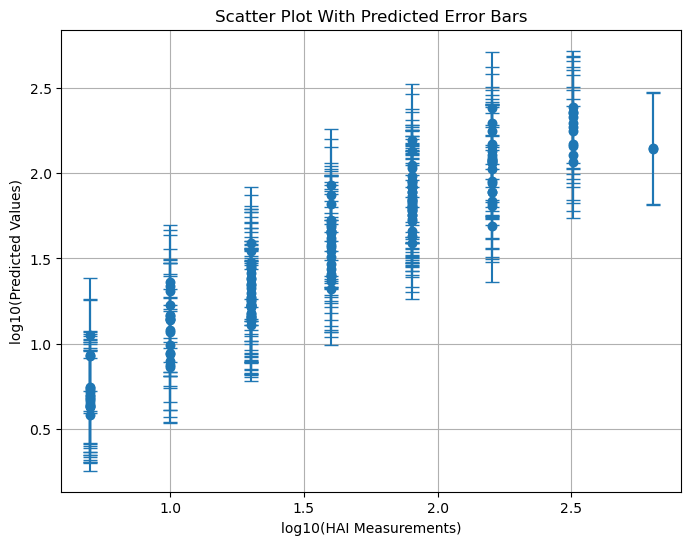

In [6]:
import matplotlib.pyplot as plt

# Assuming 'feature.t' is the feature you want to use as the x-axis
x_data = data_t[feature_t]

# 'out' contains the predictions
y_data = results['predictions']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5)
plt.xlabel("log10(HAI Measurements)")
plt.ylabel("log10(Predicted Values)")
plt.title("Scatter Plot With Predicted Error Bars")
plt.grid(True)


plt.errorbar(data_t[feature_t], y_data,
             yerr=results['errors'], fmt='o', capsize=5, label="Error Bars")

# Actual prediction error (as n-folds)
# actual_error = 10 ** np.sqrt(np.mean((np.log10(y_train) - np.log10(y_pred)) ** 2))
# print("Actual Prediction Error (as n-folds):", actual_error)


plt.show()

In [18]:
train_table = filtered_flu_table_dict['TableS5'][0]
feature_t = "A/FUJIAN/140/2000"
predict_table='TableS14'
data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1) # Data that we want to make prediction on 
selected_viruses_list = ["A/NEW_YORK/55/2004", "A/PANAMA/2007/99", "A/WELLINGTON/96/93", "BI/16190/68", "A/TASMANIA/1/97"] # Virses to use for training and predicting

n_feature = 5
n_tree=50
f_sample=0.3
n_best_tree=5
k=1

'''
When talking about cross-validation RMSE,
I train a tree on data (5 selected viruses X subset of sera) and make predictions
on testing/validating data (5 selected viruses X all viable sera that weren't used for training).
I believe that I am cross validating on Sera as selected viruses remain constant

accuracy of a tree trained on
'''

data_assist_train = np.log10(train_table) # Main dataframe used in training and validation (Perform log10 transform)
# Choose viruses that are covered by 80% of sera 
if (data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).sum() > n_feature:
    # f_col_ind_train should be a list of viruses covered by >80% of sera
    f_col_ind_train = list(data_assist_train.columns[(data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).tolist()]) # Only consider viruses that are covered by > 80% of sera in study
    if feature_t in f_col_ind_train:
        f_col_ind_train.remove(feature_t)
else:
    print(f"n_feature too large for assisting data {k}! Skipped to next data.")
f_tmp_ind = [data_t.columns.get_loc(col) for col in f_col_ind_train if col in data_t.columns] # Find indices of columns that intersect f_col_ind_train and data_t
f_feasible = [col for col in data_t.columns[f_tmp_ind] if data_t[col].count() > 2] # Choose viruses that have more than 2 sera values in prediction data
f_col_ind_train = [col for col in f_col_ind_train if col in f_feasible] # Intersects cols from f_feasible and f_col_ind_train
if len(f_feasible) < 2:
    print(f"n_feature too large for assisting data {k}! Skipped to next data.")

data_assist_train = data_assist_train.dropna(subset=[feature_t]) # Drops NAs in training data for target

In [19]:
# virus_col_sel = np.random.choice(f_ind, n_feature, replace=True) # Random viruses to train on
virus_col_sel = np.array(selected_viruses_list) # Viruses we specifically want to train on and use for predictions in predicting data
sera_row_sel = np.random.choice(data_assist_train.shape[0], int(data_assist_train.shape[0] * f_sample), replace=True) # Randomly selected sera
# We want to include the column of f_t_ind into our data_train
data_train = data_assist_train.iloc[sera_row_sel][np.append(virus_col_sel,feature_t)] # Training data subset covering virus_col_sel viruses and sera_row_sel sera
col_mean_t = data_train.apply(lambda x: x.mean(), axis=1) # Prepare to mean center the training data
data_train = data_train - np.outer(np.ones(data_train.shape[1]), col_mean_t).T # Mean center the training data
data_train.columns = np.append(virus_col_sel, "target")

dtr = DecisionTreeRegressor(min_samples_split=5)
dtr.fit(data_train.iloc[:, :-1], data_train["target"]) # Train on selected viruses and sera, test with target virus

# Compile testing dataset, really performing cross validation
data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
col_mean_t = data_test.apply(lambda x: x.mean(), axis=1)
data_test = data_test - np.outer(np.ones(data_test.shape[1]), col_mean_t).T
pred_t = dtr.predict(data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data
RMSE = np.sqrt(np.mean((pred_t - data_test[feature_t]) ** 2))




In [20]:
data_t.columns

Index(['A/AUCKLAND/20/2003', 'A/AUCKLAND/5/96', 'A/BANGKOK/1/97',
       'A/BEIJING/32/92', 'A/BRISBANE/10/2007', 'A/BRISBANE/22/94',
       'A/BRISBANE/22/96', 'A/BRISBANE/3/2005', 'A/BRISBANE/342/2003',
       'A/BRISBANE/5/2002', 'A/CALIFORNIA/7/2004', 'A/CANBERRA/1/96',
       'A/CANBERRA/9/97', 'A/CHRISTCHURCH/1/96', 'A/CHRISTCHURCH/68/99',
       'A/FUJIAN/140/2000', 'A/FUJIAN/411/2002', 'A/FUKUOKA/55/2002',
       'A/JOHANNESBURG/33/94', 'A/NANCHANG/933/95', 'A/NEW_YORK/55/2004',
       'A/NEWCALEDONIA/12/2004', 'A/PANAMA/2007/99', 'A/PERTH/16/2009',
       'A/PERTH/27/2007', 'A/PERTH/5/97', 'A/PERTH/9/97',
       'A/PHILIPPINES/427/2002_MDCK', 'A/PHILIPPINES/472/2002_EGG',
       'A/SHANDONG/9/93', 'A/SINGAPORE/37/2004', 'A/SOUTH_AUSTRALIA/53/2001',
       'A/SOUTH_AUSTRALIA/84/2002', 'A/SYDNEY/228/2000', 'A/SYDNEY/5/97',
       'A/TASMANIA/1/97', 'A/TOWNSVILLE/2/99', 'A/TOWNSVILLE/36/2003',
       'A/TOWNSVILLE/4/2002', 'A/URUGUAY/716/2007', 'A/VICTORIA/1/93',
       'A/VICTOR

In [271]:
def between_table_trees(target_table: "pd.DataFrame",
                        source_tables: "list(pd.DataFrame)",
                        feature_t: "str",
                        selected_viruses_list: "bool OR list(str)" = False,
                        n_feature = 5,
                        f_sample=0.3,
                        k=1):
    '''
    Virus Selection: selected_viruses_list can be either False for random virus selection or a list of viruses
    
    Each source table is used for training a tree and finding its
    associated cross-validation RMSE. Table which you want to make
    predictions on is also required so that trees can be trained 
    with relevant viruses.
    
    - target_table should be a dataframe where columns are viruses
      and row indices are seras. The value for each virus-serum pair
      is an HAI score for binding.
    - tables source_tables are analagous to target_table in structure
    
    Do yourself:
    - Evaluate tree using target_table data (data_t) that possesses
      selected viruses
      
    When talking about cross-validation RMSE,
    I train a tree on data (5 selected viruses X subset of sera) and make predictions
    on testing/validating data (5 selected viruses X all viable sera that weren't used for training).
    I believe that I am cross validating on Sera as selected viruses remain constant

    accuracy of a tree trained on
    '''
#     np.random.seed(42) # Random seed selection
    skipped_viruses = [] # For viruses which have absolutely no sera data in training dataset, skip
    tree_dict = dict() # Will contain trained tree, cross-validation RMSE, and (truth, predictions) for cross validation 
    for idx, train_table in enumerate(source_tables):
        
        # Feature selection step
        
        data_t = target_table # Data that we want to make prediction on 
        data_assist_train = train_table #np.log10(train_table) # Main dataframe used in training and validation (Perform log10 transform)
        # Choose viruses that are covered by 80% of sera 
        if (data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).sum() > n_feature:
            # f_col_ind_train should be a list of viruses covered by >80% of sera
            f_col_ind_train = list(data_assist_train.columns[(data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).tolist()]) # Only consider viruses that are covered by > 80% of sera in study
            if feature_t in f_col_ind_train:
                f_col_ind_train.remove(feature_t)
        else:
            print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        f_tmp_ind = [data_t.columns.get_loc(col) for col in f_col_ind_train if col in data_t.columns] # Find indices of columns that intersect f_col_ind_train and data_t
        f_feasible = [col for col in data_t.columns[f_tmp_ind] if data_t[col].count() > 2] # Choose viruses that have more than 2 sera values in prediction data
        f_col_ind_train = [col for col in f_col_ind_train if col in f_feasible] # Intersects cols from f_feasible and f_col_ind_train
        if len(f_feasible) < 2:
            print(f"n_feature too large for assisting data {k}! Skipped to next data.")
#         print("data_assist_train shape before dropna", data_assist_train.shape) # Ok, we just want to drop rows where there are NAs for feature right?
        data_assist_train = data_assist_train.dropna(subset=[feature_t]) # Drops NAs in training data for target
#         print("data_assist_train shape after dropna", data_assist_train.shape)
        # Training step (and single cross validation):
        if data_assist_train.shape[0] == 0:  # If training dataset has no sera binding data on target virus, skip (impossible to predict target)
            continue
        # virus_col_sel = np.random.choice(f_ind, n_feature, replace=True) # Random viruses to train on
        if selected_viruses_list: # If selected_viruses_list is not False, I'm assuming its just a list of virus names
            virus_col_sel = np.array(selected_viruses_list) # Viruses we specifically want to train on and use for predictions in predicting data
        else:
            features_list = list(data_assist_train.columns) # Make sure feature_t isn't in features to train on
            features_list.remove(feature_t)
            virus_col_sel = np.random.choice(f_feasible, n_feature, replace=True)
#             virus_col_sel = np.random.choice(features_list, n_feature, replace=True) # I should be sampling from list of feasible viruses!!!
#         print("data_assist_train shape ", data_assist_train.shape)
        sera_row_sel = np.random.choice(data_assist_train.shape[0], int(data_assist_train.shape[0] * f_sample), replace=True) # Randomly selected sera
        # We want to include the column of f_t_ind into our data_train
        data_train = data_assist_train.iloc[sera_row_sel][np.append(virus_col_sel,feature_t)] # Training data subset covering virus_col_sel viruses and sera_row_sel sera
        
        col_mean_t = data_train.apply(lambda x: x.mean(), axis=1) # Prepare to mean center the training data
        data_train = data_train - np.outer(np.ones(data_train.shape[1]), col_mean_t).T # Mean center the training data
        data_train.columns = np.append(virus_col_sel, "target")
#         print("selected sera: ", sera_row_sel)
#         print("data_train shape: ", data_train.shape)
#         print("data_train.iloc[:, :-1] shape: ", data_train.iloc[:, :-1].shape)
#         print("data_train['target'] shape: ", data_train["target"].shape)
        
        dtr = DecisionTreeRegressor(min_samples_split=5)
        dtr.fit(data_train.iloc[:, :-1], data_train["target"]) # Train on selected viruses and sera, evaluate with target virus

        # Compile testing dataset, really performing a single cross validation on data
        data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
#         print("data_test shape: ", data_test.shape)
        col_mean_t = data_test.apply(lambda x: x.mean(), axis=1)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), col_mean_t).T
#         print(f"data_test.columns: {data_test.columns}")
        pred_t = dtr.predict(data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data
#         print(f"Target virus: {feature_t}")
#         print("pred_t, data_test[feature_t]", pred_t.shape, data_test[feature_t].shape)
#         print(data_test[feature_t])
        RMSE = np.sqrt(np.mean((pred_t - data_test[feature_t]) ** 2))
        
        # Compile real testing dataset using data_t for cross-table RMSC
        # virus_col_sel = np.random.choice(f_ind, n_feature, replace=True) # Random viruses to train on
        cross_virus_col_sel = virus_col_sel # Viruses we specifically want to train on and use for predictions in predicting data
        cross_sera_row_sel = np.random.choice(data_t.shape[0], int(data_t.shape[0] * f_sample), replace=True) # Randomly selected sera        data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
#         cross_data_test = data_t.drop([data_t.index[idx] for idx in cross_sera_row_sel], axis=0)[np.append(cross_virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        cross_data_test = data_t[np.append(cross_virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        cross_data_test_first = data_t[np.append(cross_virus_col_sel, feature_t)]
        cross_col_mean_t = cross_data_test.apply(lambda x: x.mean(), axis=1)
        cross_data_test = cross_data_test - np.outer(np.ones(cross_data_test.shape[1]), cross_col_mean_t).T
        cross_pred_t = dtr.predict(cross_data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data
        
        cross_RMSE = np.sqrt(np.mean((cross_pred_t - cross_data_test[feature_t]) ** 2))
        if np.isnan(cross_RMSE):
            '''
            Problems with cross_data_test[feature_t]
            - Select better viruses to train on! Likely reason for failure is that im not choosing trainable viruses
            '''
#             print(f"feasible viruses: {f_feasible}")
#             print(f"Selected viruses: {virus_col_sel}")
#             print(f"Are selected viruses in feasible viruses? {[True if v in f_feasible else False for v in virus_col_sel]}")

#             print(f"cross_pred_t.shape, cross_data_test[feature_t].shape: ", cross_pred_t.shape, cross_data_test[feature_t].shape)
#             print(f"cross_col_mean_t.shape: ", cross_col_mean_t.shape)
#             print(f"cross_data_test.shape: {cross_data_test.shape}")
#             print()
            print("cross_pred_t... If this is nan, prob because predictions failed on given data\n", cross_pred_t)
#             print("cross_data_test[feature_t]... If this is nan, prob bc data_t wasn't filtered right (non viable sera rows chosen!)\n", cross_data_test[feature_t])
#             print("cross_data_test_first before mean centering: ", cross_data_test_first)
#             print("cross_data_test after mean centering: ", cross_data_test)
            
        tree_name = f'tree_{idx}_{feature_t}'
#         tree_dict[tree_name] = [dtr, RMSE, cross_RMSE, (data_test.iloc[:, :-1], pred_t)]
        tree_dict[tree_name] = [dtr, RMSE, cross_RMSE, sum(cross_pred_t), sum(cross_data_test[feature_t])]
    return tree_dict
    

In [257]:
'''
Draw up a boxplot for each tree, covering the RMSEs recorded
by running many times
'''
names = ['S1_S14', 'S3_S14', 'S5_S14', 'S13_S14']
intra_RMSE = {key:[] for key in names}
cross_RMSE = {key:[] for key in names}

tableS3  = data_df.loc[data_df['sera_table']=="TableS3"].drop(['sera_table'], axis=1)
tableS5  = data_df.loc[data_df['sera_table']=="TableS5"].drop(['sera_table'], axis=1)
tableS1  = data_df.loc[data_df['sera_table']=="TableS1"].drop(['sera_table'], axis=1)
tableS13 = data_df.loc[data_df['sera_table']=="TableS13"].drop(['sera_table'], axis=1)
tableS14 = data_df.loc[data_df['sera_table']=="TableS14"].drop(['sera_table'], axis=1)
for i in range(100):
    trees_targeting_S14 = between_table_trees(
                                             target_table=tableS14,
                                             source_tables=[tableS1, tableS3, tableS5, tableS13],
                                             feature_t="A/FUJIAN/140/2000",
                                             )
    
    S1_to_S14_RMSE  = trees_targeting_S14['tree_0_A/FUJIAN/140/2000'][1]
    S3_to_S14_RMSE  = trees_targeting_S14['tree_1_A/FUJIAN/140/2000'][1]
    S5_to_S14_RMSE  = trees_targeting_S14['tree_2_A/FUJIAN/140/2000'][1]
    S13_to_S14_RMSE = trees_targeting_S14['tree_3_A/FUJIAN/140/2000'][1]
    intra_RMSE['S1_S14'].append(S1_to_S14_RMSE)
    intra_RMSE['S3_S14'].append(S3_to_S14_RMSE)
    intra_RMSE['S5_S14'].append(S5_to_S14_RMSE)
    intra_RMSE['S13_S14'].append(S13_to_S14_RMSE)
    
    S1_to_S14_cross_RMSE  = trees_targeting_S14['tree_0_A/FUJIAN/140/2000'][2]
    S3_to_S14_cross_RMSE  = trees_targeting_S14['tree_1_A/FUJIAN/140/2000'][2]
    S5_to_S14_cross_RMSE  = trees_targeting_S14['tree_2_A/FUJIAN/140/2000'][2]
    S13_to_S14_cross_RMSE = trees_targeting_S14['tree_3_A/FUJIAN/140/2000'][2]
    cross_RMSE['S1_S14'].append(S1_to_S14_cross_RMSE)
    cross_RMSE['S3_S14'].append(S3_to_S14_cross_RMSE)
    cross_RMSE['S5_S14'].append(S5_to_S14_cross_RMSE)
    cross_RMSE['S13_S14'].append(S13_to_S14_cross_RMSE)
    

/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

<Axes: title={'center': 'Intra-table RSMC'}, xlabel='Table', ylabel='Intra-table RSMC'>

/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


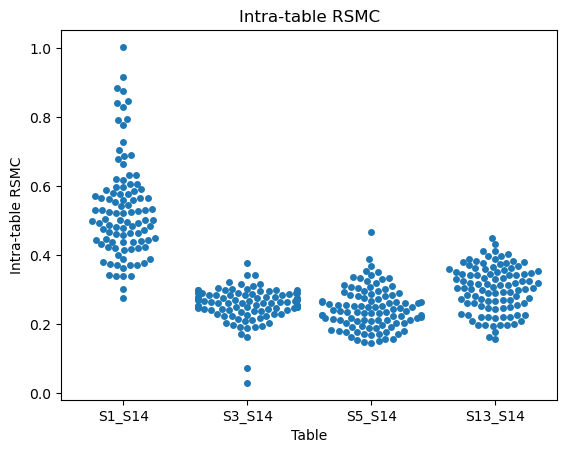

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt
intra_RMSE_df = pd.DataFrame(intra_RMSE)
plt.title("Intra-table RSMC")
sns.swarmplot(x="Table", y="Intra-table RSMC", data=pd.melt(intra_RMSE_df, var_name="Table", value_name="Intra-table RSMC"))


/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

<Axes: title={'center': 'Cross-table RSMC'}, xlabel='Table', ylabel='Cross-table RSMC'>

/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


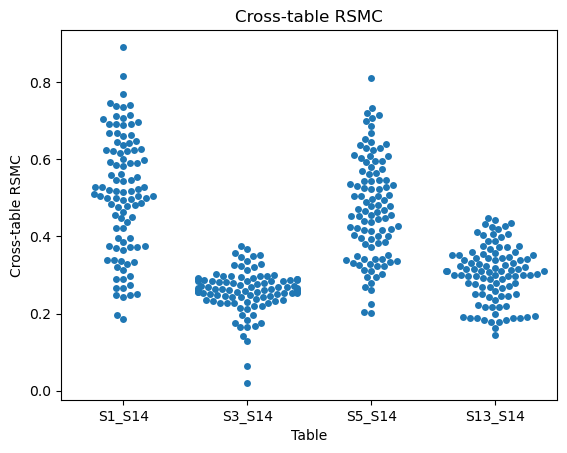

In [259]:
import seaborn as sns
cross_RMSE_df = pd.DataFrame(cross_RMSE)
plt.title("Cross-table RSMC")
sns.swarmplot(x="Table", y="Cross-table RSMC", data=pd.melt(cross_RMSE_df, var_name="Table", value_name="Cross-table RSMC"))


Text(0.5, 0.01, 'Intra Table RMSE')

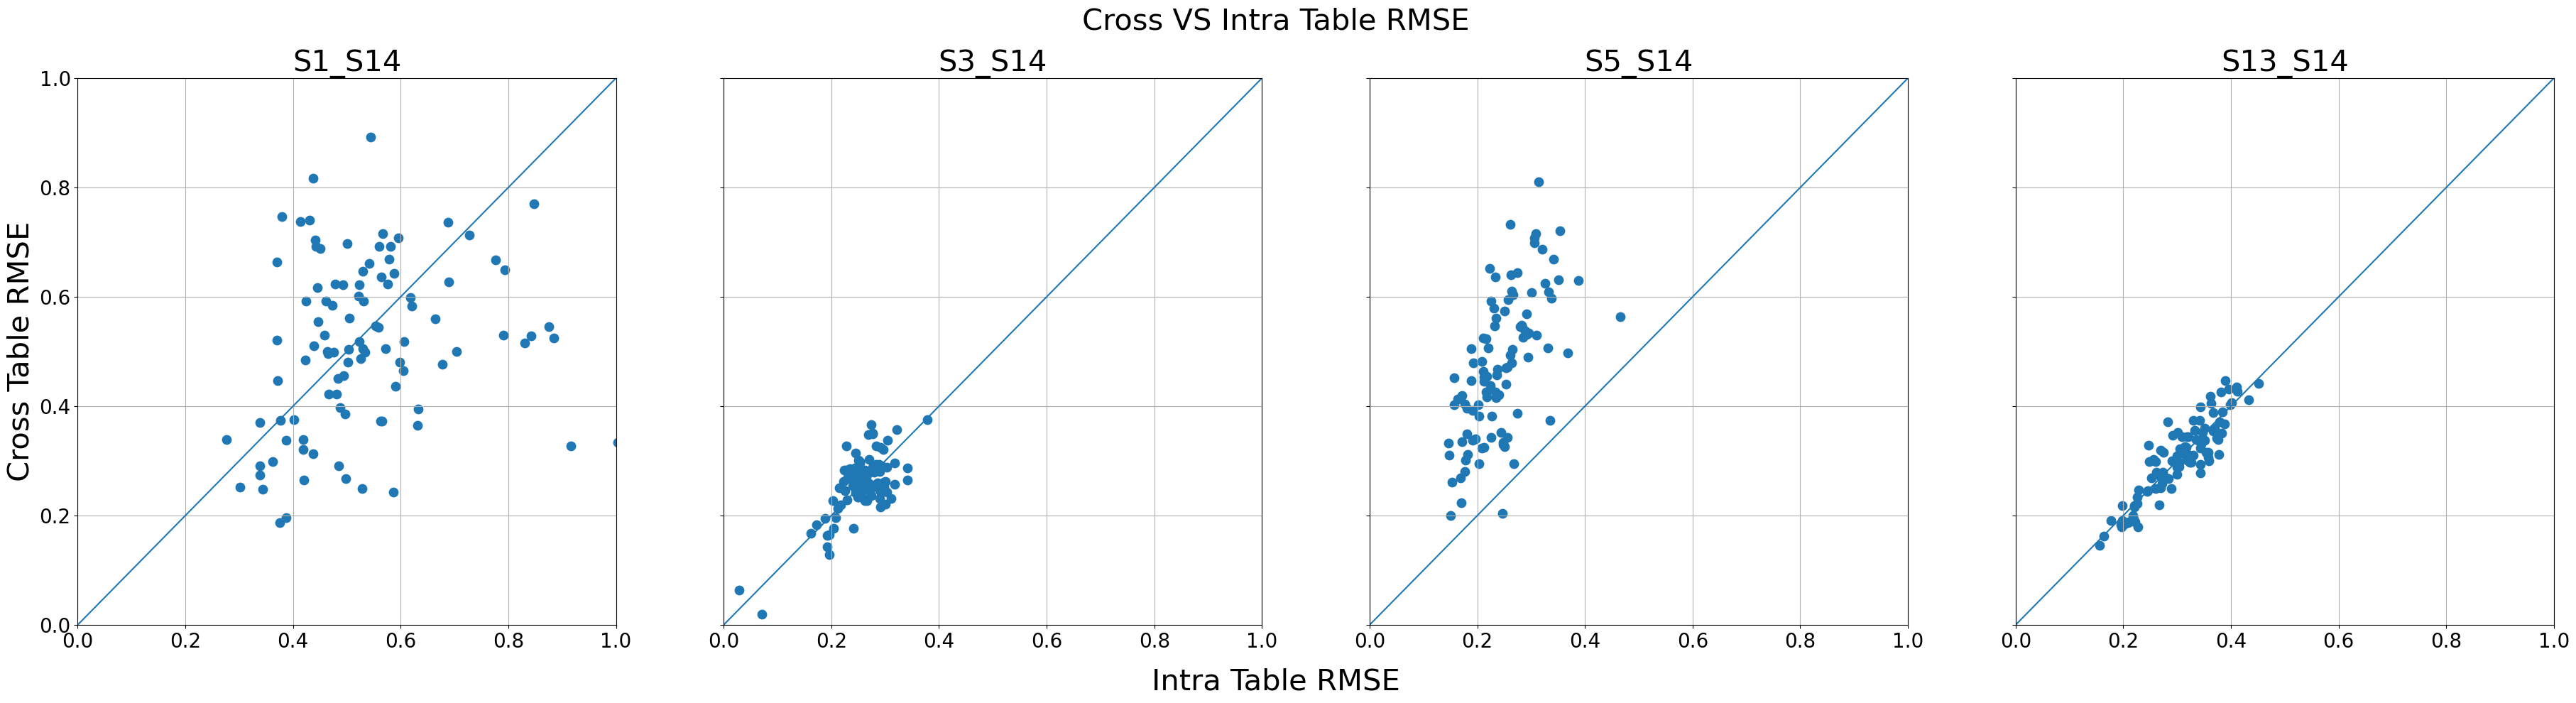

In [260]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(45,10),
                        sharex=True, sharey=True,)
for idx, name in enumerate(names):
    x = intra_RMSE_df[name]
    y = cross_RMSE_df[name]
    
    axs[idx].scatter(x,y, s=80)
    axs[idx].set_title(name, fontsize = 30)
    axs[0].set_ylabel("Cross Table RMSE", fontsize = 30)
    axs[idx].tick_params(axis='both', which='major', labelsize=20)
    axs[idx].grid()
    axs[idx].plot([0, 1], [0, 1], transform=axs[idx].transAxes)
plt.xlim([0, 1])
plt.ylim([0, 1])
fig.suptitle("Cross VS Intra Table RMSE", fontsize=30)
fig.supxlabel('Intra Table RMSE', fontsize=30)


In [261]:
S1_to_S14_RMSE  = trees_targeting_S14['tree_0_A/FUJIAN/140/2000'][1]
S3_to_S14_RMSE  = trees_targeting_S14['tree_1_A/FUJIAN/140/2000'][1]
S5_to_S14_RMSE  = trees_targeting_S14['tree_2_A/FUJIAN/140/2000'][1]
S13_to_S14_RMSE = trees_targeting_S14['tree_3_A/FUJIAN/140/2000'][1]

print(f"S1_to_S14_RMSE : {S1_to_S14_RMSE }")
print(f"S3_to_S14_RMSE : {S3_to_S14_RMSE }")
print(f"S5_to_S14_RMSE : {S5_to_S14_RMSE }")
print(f"S13_to_S14_RMSE: {S13_to_S14_RMSE}")

S1_to_S14_RMSE : 0.5030594767322272
S3_to_S14_RMSE : 0.25015089287164455
S5_to_S14_RMSE : 0.30136257781024967
S13_to_S14_RMSE: 0.31628800198289064


# Creating Figure S1

### Notes:
- Somethings up with "HN196/2009" ?
    - Apparently its only found in tables S1 and S3
    - Could we do a weird network thing where we impute values for the rest of the tables (S5, S5, S13, S14) by
      finding which tables are most immediately transferable with each other? Might be cool way of forming a DAG
      to satisfy missing values between tables (or naive lol)
      
- Issue with computing Cross RMSEs for some viruses
    - Could be insufficient sera which are feasible for training?

In [262]:
print(f'Total NAs for HN196/2009 in flu dataset: {sum([1 for i in flu_df["HN196/2009"].tolist() if i == "*"])}')
print(f"Unique values in flu dataset: {flu_df['HN196/2009'].unique()}")
for idx, table in enumerate(table_list):
    print(f"{table_names[idx]}: ", table['HN196/2009'].unique())

Total NAs for HN196/2009 in flu dataset: 1005
Unique values in flu dataset: ['*' '5' '320' '160' '80' '640' '20' '40' '10']
tableS5:  [nan]
tableS6:  [nan]
tableS13:  [nan]
tableS14:  [nan]
tableS3:  [0.69897    1.30103           nan 1.60205999 1.         2.20411998
 1.90308999 2.80617997]
tableS1:  [       nan 0.69897    2.50514998 2.20411998 1.90308999 2.80617997]


In [263]:
tableS5['HN196/2009']

Measurements (Sera in Rows/Viruses in Columns)
Subject258Age29_Pre_TableS5    NaN
Subject548Age74_Pre_TableS5    NaN
Subject61Age19_Pre_TableS5     NaN
Subject147Age18_Pre_TableS5    NaN
Subject150Age18_Pre_TableS5    NaN
                                ..
Subject529Age69_Post_TableS5   NaN
Subject3Age20_Post_TableS5     NaN
Subject524Age69_Post_TableS5   NaN
Subject505Age72_Post_TableS5   NaN
Subject501Age65_Post_TableS5   NaN
Name: HN196/2009, Length: 212, dtype: float64

In [264]:
tableS6['HN196/2009']

Measurements (Sera in Rows/Viruses in Columns)
Subject71Age18_Pre_TableS6     NaN
Subject77Age19_Pre_TableS6     NaN
Subject88Age19_Pre_TableS6     NaN
Subject90Age19_Pre_TableS6     NaN
Subject99Age27_Pre_TableS6     NaN
                                ..
Subject637Age66_Post_TableS6   NaN
Subject672Age73_Post_TableS6   NaN
Subject621Age74_Post_TableS6   NaN
Subject104Age26_Post_TableS6   NaN
Subject109Age21_Post_TableS6   NaN
Name: HN196/2009, Length: 256, dtype: float64

In [272]:
tableS1  = data_df.loc[data_df['sera_table']=="TableS1"].drop(['sera_table'], axis=1)
tableS3  = data_df.loc[data_df['sera_table']=="TableS3"].drop(['sera_table'], axis=1)
tableS5  = data_df.loc[data_df['sera_table']=="TableS5"].drop(['sera_table'], axis=1)
tableS6  = data_df.loc[data_df['sera_table']=="TableS6"].drop(['sera_table'], axis=1)
tableS13 = data_df.loc[data_df['sera_table']=="TableS13"].drop(['sera_table'], axis=1)
tableS14 = data_df.loc[data_df['sera_table']=="TableS14"].drop(['sera_table'], axis=1)
# table_names = ["tableS1" , "tableS3" , "tableS5" , "tableS6" , "tableS13", "tableS14"]
# table_list = [tableS1 , tableS3 , tableS5 , tableS6 , tableS13, tableS14]
table_names = ["tableS5" , "tableS6" , "tableS13" , "tableS14" , "tableS3", "tableS1"]
table_list = [tableS5 , tableS6 , tableS13 , tableS14 , tableS3, tableS1]

comparison_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            tree_dict = dict() # Contains {trees and RMSE data} collected from training a tree on target features of target_table
            # Preparing tree parameters
            feature_targets = list(target_table.columns) # List of viruses to make a tree/prediction on
            for i, feature_target in enumerate(feature_targets): # Make a tree for each virus in target_table
                tree = between_table_trees(
                                          target_table=target_table,
                                          source_tables=[source_table], # Feed in a list containing our single source table (functionality on multiple source tables is intended (WIP))
                                          selected_viruses_list=False, # Set selected_viruses_list to false to randomly select viruses to train on
                                          feature_t=feature_target,
                                          )
                if len(tree) != 0:
                    tree_dict[feature_target] = tree
            comparison_dict[comparison_name] = tree_dict
            print("----------------")
            print(f"Comparison from {source_table_name} to {target_table_name} completed")
    


----------------
Comparison from tableS5 to tableS6 completed
cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.12542916  0.12542916  0.12542916  0.12542916  0.75257499  0.12542916
  0.30103     0.12542916  0.8863661   0.12542916  0.12542916  0.12542916
  0.12542916  0.75257499  0.25085833  0.25085833  0.          0.8863661
  0.75257499  0.75257499  0.12542916  0.12542916 -0.05017167  0.75257499
  0.12542916  0.12542916  0.12542916  0.12542916  0.          0.25085833
  0.12542916  0.12542916  0.12542916  0.25085833  0.8863661   0.75257499
  0.12542916  0.30103     0.30103     0.          0.8863661   0.8863661
  0.8863661   0.12542916  0.25085833  0.12542916  0.75257499  0.12542916
  0.8863661   0.12542916  0.8863661   0.8863661   0.8863661   0.12542916
  0.8863661   0.12542916  0.8863661   0.8863661   0.8863661   0.25085833
  0.75257499  0.8863661   0.8863661   0.12542916  0.8863661   0.8863661
  0.12542916  0.8863661   0.12542916  0.12542916  0.1254291

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-3.01029996e-01  7.40148683e-17 -3.13572912e-01  5.01716659e-01
  4.51544993e-01  7.40148683e-17  4.51544993e-01  7.40148683e-17
  7.40148683e-17 -1.75600831e-01 -3.13572912e-01  4.51544993e-01
  4.51544993e-01  7.40148683e-17  7.40148683e-17  4.51544993e-01
 -1.75600831e-01  4.51544993e-01  7.40148683e-17  7.40148683e-17
 -1.75600831e-01 -4.18097216e-01 -1.75600831e-01  4.51544993e-01
  7.40148683e-17  0.00000000e+00  4.51544993e-01 -1.75600831e-01
  7.40148683e-17 -1.75600831e-01 -5.26802492e-01  7.40148683e-17
  7.40148683e-17 -1.75600831e-01  4.51544993e-01  7.40148683e-17
 -1.75600831e-01  7.40148683e-17 -1.75600831e-01 -3.13572912e-01
 -3.13572912e-01  7.40148683e-17 -4.18097216e-01  7.40148683e-17
 -4.18097216e-01  0.00000000e+00 -3.13572912e-01  0.00000000e+00
  7.40148683e-17  4.51544993e-01  7.40148683e-17  4.51544993e-01
 -3.76287495e-01 -1.75600831e-01  7.40148683e-17 -1.75600831e-01
 -1.7560083

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.55188833 -0.05017167 -0.33447777 -0.35120166 -0.35120166 -0.33447777
 -0.05017167 -0.11288625 -0.05017167 -0.150515   -0.60205999 -0.05017167
 -0.57697416 -0.33447777 -0.05017167 -0.57697416 -0.27594416 -0.57697416
 -0.11288625 -0.33447777 -0.60205999 -0.55188833 -0.48499277 -0.35120166
 -0.05017167 -0.33447777 -0.57697416 -0.35120166 -0.05017167 -0.27594416
 -0.35120166 -0.05017167 -0.33447777 -0.11288625 -0.57697416 -0.05017167
 -0.75257499 -0.05017167 -0.35120166 -0.11288625 -0.33447777 -0.05017167
 -0.05017167  0.30103    -0.20068666 -0.150515   -0.11288625 -0.60205999
 -0.57697416 -0.57697416 -0.05017167  0.30103    -0.33447777  0.30103
  0.30103    -0.60205999 -0.27594416 -0.05017167  0.30103    -0.20068666
 -0.05017167  0.30103    -0.33447777 -0.20068666 -0.33447777 -0.05017167
 -0.11288625 -0.57697416 -1.15394832 -0.55188833 -0.57697416 -0.83619443
 -0.05017167 -0.60205999 -0.85291832 -0.57697416

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.05017167 -0.30103    -0.30103    -0.20068666 -0.33447777 -0.33447777
 -0.26758222 -0.11706722 -0.52680249 -0.05017167 -0.26758222 -0.33447777
 -0.20068666  0.         -0.05017167 -0.33447777 -0.150515   -0.20068666
 -0.26758222 -0.30103     0.         -0.33447777  0.         -0.33447777
 -0.150515   -0.26758222 -0.05017167 -0.30103    -0.11706722 -0.30103
  0.         -0.30103    -0.05017167 -0.33447777 -0.05017167 -0.26758222
 -0.11706722 -0.30103    -0.11706722 -0.30103    -0.63968874 -0.30103
 -0.20068666 -0.05017167 -0.05017167 -0.05017167 -0.05017167 -0.47663083
 -0.20068666 -0.26758222 -0.33447777 -0.26758222 -0.20068666 -0.05017167
 -0.33447777 -0.43900208 -0.05017167 -0.05017167 -0.05017167 -0.05017167
 -0.20068666 -0.20068666 -0.11706722 -0.26758222 -0.05017167 -0.33447777
  0.         -0.33447777 -0.05017167 -0.52680249 -0.150515   -0.05017167
 -0.33447777 -0.33447777 -0.20068666 -0.33447777 -0

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.25085833 -0.20068666 -0.60205999 -0.20068666 -0.05017167 -0.05017167
 -0.05017167 -0.30103    -0.30103    -0.05017167 -0.05017167 -0.05017167
 -1.15394832  0.25085833 -0.20068666 -0.05017167  0.25085833 -1.00343332
  0.25085833 -0.30103     0.25085833  0.25085833  0.25085833 -0.80274666
 -0.60205999  0.25085833 -0.05017167  0.25085833  0.25085833 -0.05017167
 -0.05017167 -0.05017167 -0.05017167 -0.30103     0.25085833 -0.50171666
 -0.30103     0.25085833  0.25085833 -0.150515   -0.05017167 -0.30103
  0.25085833 -0.05017167  0.25085833 -0.30103     0.25085833  0.25085833
  0.25085833 -0.150515    0.25085833  0.25085833 -1.15394832 -0.05017167
 -1.15394832 -0.30103     0.25085833  0.25085833 -0.60205999 -0.150515
  0.25085833 -0.05017167 -0.05017167 -0.05017167 -0.60205999  0.25085833
 -0.20068666 -0.30103    -0.30103     0.25085833 -0.60205999  0.25085833
  0.25085833 -0.05017167  0.25085833  0.25085833 -

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.01254292 -0.01254292 -0.01254292  0.66477457  0.66477457  0.85291832
  0.35120166  0.35120166  0.95326165  0.36374458  0.35120166  0.66477457
 -0.150515    0.66477457  0.36374458  0.25085833 -0.150515    0.36374458
  0.35120166 -0.01254292 -0.01254292  0.36374458  0.32611583  0.35120166
 -0.150515    0.66477457  0.70240332  0.36374458 -0.150515    0.66477457
  0.85291832  0.66477457  0.70240332  0.76511791  0.35120166  0.30103
  0.36374458 -0.48499277  0.28430611 -0.01254292  0.66477457 -0.01254292
  0.32611583  0.70240332  0.35120166 -0.01254292  0.32611583  0.70240332
  0.66477457  0.35120166  0.25085833 -0.25085833  0.32611583  0.70240332
  0.25085833  0.36374458  0.36374458 -0.01254292  0.28430611 -0.01254292
  0.32611583  0.66477457  0.25085833  0.35120166 -0.01254292  0.66477457
  0.66477457  0.98670943 -0.01254292  0.28430611 -0.01254292  0.32611583
  0.36374458  0.36374458  0.32611583  0.36374458

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.150515   -0.150515   -0.150515   -0.150515   -0.150515   -0.17309225
 -0.150515   -0.150515   -0.150515   -0.150515   -0.150515   -0.22075533
 -0.150515   -0.150515   -0.150515   -0.150515   -0.150515   -0.08027467
 -0.150515   -0.150515   -0.150515   -0.150515   -0.08027467 -0.150515
 -0.150515   -0.150515   -0.08027467 -0.150515   -0.150515   -0.150515
 -0.150515   -0.150515   -0.150515   -0.150515   -0.08027467 -0.150515
 -0.150515   -0.150515   -0.150515   -0.08027467 -0.150515   -0.150515
 -0.150515   -0.150515   -0.17309225 -0.150515   -0.150515   -0.150515
 -0.08027467 -0.150515   -0.150515   -0.08027467 -0.08027467 -0.08027467
 -0.08027467 -0.08027467 -0.08027467 -0.08027467 -0.08027467 -0.08027467
 -0.22075533 -0.22075533 -0.08027467 -0.08027467 -0.08027467 -0.08027467
 -0.08027467 -0.08027467 -0.08027467 -0.22075533 -0.17309225 -0.17309225
 -0.17309225 -0.22075533 -0.22075533 -0.150515   -0.220

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.48164799 -0.48164799 -0.48164799 -0.48164799 -0.48164799 -0.10034333
 -0.40137333 -0.30103    -0.40137333 -0.40137333 -0.40137333 -0.10034333
 -0.40137333 -0.40137333 -0.40137333 -0.40137333 -0.40137333 -0.48164799
 -0.48164799 -0.40137333 -0.48164799 -0.48164799 -0.10034333 -0.40137333
 -0.40137333 -0.30103    -0.10034333 -0.40137333 -0.10034333 -0.48164799
 -0.48164799 -0.48164799 -0.48164799 -0.48164799 -0.10034333 -0.48164799
 -0.48164799 -0.48164799 -0.48164799 -0.48164799 -0.40137333 -0.30103
 -0.40137333 -0.40137333 -0.10034333 -0.30103    -0.30103    -0.30103
 -0.10034333 -0.30103    -0.40137333 -0.48164799  0.11706722  0.11706722
  0.11706722  0.11706722  0.11706722  0.11706722 -0.10034333 -0.10034333
 -0.10034333  0.11706722  0.11706722  0.11706722  0.11706722  0.11706722
  0.11706722  0.11706722 -0.12821648  0.09532617 -0.10034333 -0.48164799
 -0.10034333 -0.12821648 -0.12821648 -0.30103    -0

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.56861221  0.56861221  0.56861221  0.56861221  0.56861221 -0.35120166
  0.56861221  0.56861221  0.56861221  0.56861221  0.56861221  0.27594416
  0.56861221  0.56861221  0.56861221  0.56861221  0.56861221  0.27594416
  0.56861221  0.56861221  0.56861221  0.56861221  0.27594416  0.56861221
  0.56861221  0.56861221  0.27594416  0.13379111  0.27594416  0.56861221
  0.56861221  0.56861221  0.56861221  0.56861221  0.27594416  0.56861221
  0.56861221  0.56861221  0.56861221  0.27594416  0.56861221  0.56861221
  0.56861221  0.56861221 -0.35120166  0.56861221 -0.30103    -0.30103
 -0.35120166  0.56861221  0.56861221 -0.35120166 -0.13797208 -0.13797208
  0.27594416  0.27594416  0.27594416  0.27594416  0.27594416  0.27594416
 -0.02508583  0.27594416  0.0752575   0.27594416  0.27594416  0.27594416
  0.27594416  0.27594416  0.0752575  -0.13797208  0.27594416  0.27594416
  0.27594416  0.27594416  0.27594416  0.56861221

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.35120166  0.11706722  0.51425958 -0.47663083  1.15394832  0.51425958
  0.7358511   0.51425958 -0.02508583 -0.02508583  0.85291832  0.51425958
  0.11706722 -0.02508583  0.35120166  0.7358511  -0.02508583  0.7358511
  0.11706722  0.35120166 -0.02508583  0.51425958  0.35120166  0.11706722
 -0.02508583  0.51425958  0.51425958  0.11706722  0.11706722  0.35120166
  0.27594416  0.11706722  0.35120166  0.11706722  1.15394832 -0.02508583
 -0.02508583  0.35120166 -0.02508583  0.67731749  0.51425958  0.35120166
  0.150515    0.35120166  0.35120166  0.85291832  0.51425958  0.35120166
  0.51425958  0.85291832  0.35120166  0.11706722  0.150515    1.15394832
  0.7358511   0.35120166 -0.02508583  0.35120166  0.7358511   0.35120166
  0.35120166  0.11706722  0.35120166 -0.10034333  1.15394832 -0.02508583
  0.35120166  0.11706722  0.35120166  0.35120166  0.51425958  1.15394832
 -0.02508583  0.27594416 -0.02508583  0.514259

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.33865875 -0.2257725  -0.2257725  -0.55188833 -0.37628749 -0.2257725
 -0.37628749 -0.45154499 -0.2257725  -0.33865875  0.42645916 -0.03762875
 -0.03762875 -0.37628749 -0.03762875 -0.37628749 -0.2257725  -0.150515
 -0.37628749 -0.03762875 -0.33865875 -0.35120166 -0.33865875 -0.37628749
 -0.03762875 -0.33865875  0.20068666 -0.03762875 -0.37628749 -0.2257725
 -0.43900208 -0.03762875 -0.2257725  -0.03762875 -0.37628749 -0.150515
 -0.40137333  0.20068666 -0.03762875  0.20068666 -0.55188833 -0.03762875
 -0.23413444  0.20068666 -0.23413444  1.05360498  0.20068666 -0.37628749
 -0.45154499  1.05360498 -0.03762875 -0.37628749 -0.37628749 -0.2257725
 -0.37628749 -0.45154499 -0.03762875 -0.03762875 -0.03762875 -0.40137333
 -0.37628749 -0.150515   -0.2257725  -0.45154499 -0.23413444 -0.03762875
 -0.55188833 -0.37628749 -0.33865875 -0.37628749 -0.2257725   0.20068666
 -0.03762875 -0.40137333 -0.43900208 -0.45154499  1.

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.30103    -0.30103    -0.30103    -0.30103    -0.150515   -0.30103
 -0.35120166 -0.30103    -0.05017167 -0.05017167  0.20068666 -0.30103
 -0.40137333  0.50171666 -0.30103    -0.40137333 -0.30103     0.95326165
  0.20068666 -0.30103    -0.40137333 -0.05017167  0.65223166 -0.30103
 -0.30103    -0.35120166 -0.30103    -0.30103    -0.30103    -0.30103
 -0.150515   -0.30103    -0.40137333  0.02508583 -0.35120166 -0.40137333
 -0.30103     0.02508583 -0.30103    -0.30103    -0.30103     0.65223166
 -0.30103     0.02508583  0.40137333 -0.30103    -0.30103    -0.40137333
 -0.30103    -0.30103     0.02508583 -0.05017167 -0.30103    -0.30103
 -0.30103     0.30103    -0.30103    -0.30103     0.02508583 -0.30103
 -0.30103     0.150515   -0.10034333 -0.30103     0.65223166 -0.30103
 -0.30103     0.65223166 -0.30103    -0.150515   -0.10034333  0.02508583
  0.02508583 -0.05017167  0.65223166 -0.30103    -0.30103     0.40

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.50171666  0.47663083  0.06689555 -0.05017167  0.35120166  0.47663083
  0.70240332  0.06689555  0.06689555  0.47663083  0.70240332  0.06689555
  0.06689555  0.47663083  0.06689555 -0.05017167  0.35120166  0.35120166
  0.53516444  0.50171666  0.30103     0.35120166  0.50171666  0.35120166
 -0.36792555  0.31775388  0.47663083  0.50171666 -0.05017167  0.47663083
  0.70240332  1.30446331  0.47663083 -0.36792555  0.35120166  0.06689555
  0.06689555  0.47663083  0.06689555  0.50171666  0.70240332  0.50171666
 -0.05017167 -0.05017167  0.47663083  0.50171666  0.50171666 -0.36792555
  0.50171666  0.06689555 -0.05017167 -0.05017167 -0.05017167 -0.05017167
 -0.36792555 -0.25085833 -0.36792555  0.50171666  0.          0.50171666
 -0.46408791 -0.05017167 -0.36792555  0.70240332  0.50171666  0.50171666
  0.47663083  0.06689555 -0.05017167  0.70240332  0.06689555  0.50171666
  0.          0.47663083  0.          0.06689

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.75257499  0.75257499 -0.05017167  0.75257499 -0.02508583 -0.02508583
 -0.60205999 -0.2257725  -0.30103    -0.60205999 -0.60205999  0.10034333
 -0.02508583  0.10034333 -0.40137333 -0.60205999 -0.60205999 -0.02508583
 -0.40137333  0.75257499  0.75257499 -0.60205999  0.10034333 -0.40137333
 -0.25085833 -0.40137333 -0.02508583  0.75257499 -0.60205999  0.75257499
 -0.02508583  0.75257499 -0.02508583 -0.02508583 -0.40137333 -0.60205999
  0.10034333 -0.30103    -0.60205999  0.75257499 -0.50171666  0.75257499
  0.10034333 -0.02508583 -0.40137333  0.75257499  0.75257499 -0.50171666
 -0.60205999 -0.60205999 -0.40137333 -0.50171666 -0.02508583 -0.60205999
 -0.40137333 -0.150515   -0.60205999  0.75257499 -0.35120166 -0.50171666
 -0.02508583 -0.40137333 -0.2257725  -0.60205999 -0.30103     0.10034333
  0.75257499 -0.30103    -0.05017167 -0.60205999 -0.40137333  0.75257499
 -0.2257725   0.10034333 -0.02508583  0.10034

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.27198324 -0.11288625 -0.11288625 -0.11288625 -0.11288625 -0.27198324
 -0.11288625  0.17560083  0.17560083 -0.11288625 -0.11288625 -0.27198324
  0.17560083  0.17560083  0.17560083  0.17560083  0.17560083  0.18563516
 -0.11288625 -0.11288625 -0.27198324 -0.11288625 -0.27198324 -0.27198324
 -0.27198324 -0.27198324 -0.27198324 -0.27198324 -0.27198324 -0.11288625
 -0.11288625 -0.11288625 -0.11288625 -0.11288625 -0.27198324  0.17560083
 -0.11288625 -0.11288625 -0.11288625 -0.27198324  0.17560083  0.17560083
  0.17560083  0.17560083 -0.27198324  0.17560083  0.17560083  0.17560083
  0.18563516  0.17560083  0.17560083 -0.27198324 -0.10034333 -0.10034333
  0.86546124  0.35120166  0.17560083 -0.27198324  0.17560083  0.17560083
 -0.4954452  -0.02508583  0.37628749  0.86546124  0.86546124  0.86546124
  0.86546124  0.86546124  0.05017167 -0.02508583 -0.02508583 -0.02508583
 -0.02508583 -0.02508583 -0.02508583 -0.11288

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-3.70074342e-17 -3.70074342e-17 -3.70074342e-17 -3.70074342e-17
 -3.70074342e-17  1.67238886e-01 -3.70074342e-17 -3.70074342e-17
 -3.70074342e-17 -3.70074342e-17 -3.70074342e-17 -4.84265645e-01
 -3.70074342e-17 -3.70074342e-17 -3.70074342e-17 -3.70074342e-17
 -3.70074342e-17 -6.68955546e-02 -3.70074342e-17 -3.70074342e-17
 -3.70074342e-17 -3.70074342e-17 -4.84265645e-01 -3.70074342e-17
 -3.70074342e-17 -3.70074342e-17  1.67238886e-01 -3.70074342e-17
  1.67238886e-01 -3.70074342e-17 -3.70074342e-17 -3.70074342e-17
 -3.70074342e-17 -3.70074342e-17  1.67238886e-01 -3.70074342e-17
 -3.70074342e-17 -3.70074342e-17 -3.70074342e-17  1.67238886e-01
 -1.67238886e-01 -3.70074342e-17 -3.70074342e-17 -3.70074342e-17
 -6.68955546e-02 -3.70074342e-17 -3.70074342e-17 -3.70074342e-17
 -6.68955546e-02 -3.70074342e-17 -3.70074342e-17 -6.68955546e-02
 -2.48851463e-01 -2.48851463e-01 -3.70074342e-17 -3.70074342e-17
 -3.7007434

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.45154499  0.05017167  0.05017167 -0.45154499  0.05017167  0.38883041
  0.38883041  0.38883041  0.38883041  0.38883041  0.38883041  0.38883041
  0.38883041  0.38883041  0.38883041  0.38883041  0.38883041  0.150515
 -0.45154499  0.38883041  0.38883041 -0.45154499  0.38883041 -0.45154499
  0.38883041  0.38883041  0.38883041 -0.45154499  0.38883041  0.11706722
  0.38883041  0.11706722  0.38883041  0.11706722  0.38883041  0.38883041
  0.38883041  0.38883041  0.38883041  0.38883041  0.38883041  0.38883041
  0.38883041  0.38883041  0.150515    0.38883041  0.10034333  0.10034333
  0.          0.38883041  0.38883041  0.150515    0.38883041  0.10034333
  0.150515    0.38883041  0.38883041  0.38883041  0.150515    0.150515
  0.150515    0.150515    0.38883041  0.150515    0.150515    0.150515
  0.150515    0.150515    0.38883041  0.          0.150515    0.150515
  0.150515    0.150515    0.10034333 -0.060206    0.1

----------------
Comparison from tableS6 to tableS3 completed
cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.          0.          0.          0.          0.          0.
  0.         -0.05017167  0.45154499 -0.2257725   0.45154499  0.45154499
  0.45154499  0.45154499  0.45154499  0.45154499  0.60205999  0.60205999
  0.60205999  0.60205999  0.60205999  0.60205999  0.60205999  0.60205999
 -0.0752575  -0.0752575   0.60205999  0.60205999  0.50171666  1.08496228
  1.08496228 -0.0752575  -0.05017167 -0.05017167 -0.05017167]
cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.10034333  0.10034333  0.10034333  0.10034333 -0.12710155  0.10034333
 -1.15394832 -0.25085833 -0.25085833  0.05017167  0.05017167  0.05017167
 -0.25085833 -0.25085833 -0.25085833 -0.25085833 -0.20068666  0.50171666
 -0.10034333  0.50171666 -0.32611583  0.05017167  0.05017167  0.05017167
 -0.32611583 -0.32611583 -0.32611583 -0.32611583 -0.32611583 -0.32611

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-2.38315413e-01 -5.51888325e-01 -2.38315413e-01 -1.25429165e-01
  5.55111512e-17 -2.38315413e-01 -2.38315413e-01 -3.26115829e-01
 -3.26115829e-01 -1.25429165e-01  8.40375405e-01 -5.51888325e-01
  8.40375405e-01 -5.51888325e-01  8.40375405e-01  4.89173743e-01
  5.55111512e-17  5.55111512e-17 -2.38315413e-01  8.40375405e-01
 -2.38315413e-01 -2.38315413e-01 -2.38315413e-01  4.89173743e-01
 -4.26459161e-01  5.55111512e-17 -2.38315413e-01  8.40375405e-01
 -4.26459161e-01 -4.26459161e-01 -3.26115829e-01 -5.51888325e-01
 -5.51888325e-01  5.55111512e-17 -7.02403323e-01  8.40375405e-01
 -5.51888325e-01  5.55111512e-17  8.40375405e-01  5.55111512e-17
  8.40375405e-01 -3.26115829e-01 -1.00343332e-01 -4.26459161e-01
 -5.51888325e-01 -4.26459161e-01  2.17410552e-01 -4.26459161e-01
 -1.25429165e-01  5.55111512e-17  5.55111512e-17 -1.25429165e-01
 -4.26459161e-01 -2.38315413e-01  5.55111512e-17 -1.25429165e-01
  6.6895554

----------------
Comparison from tableS13 to tableS14 completed
cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.02508583 -0.02508583 -0.02508583 -0.02508583 -0.02508583  0.40137333
 -0.02508583 -0.02508583 -0.02508583 -0.02508583 -0.02508583  0.40137333
  0.45154499 -0.26340125 -0.02508583  0.45154499  0.45154499 -0.26340125
  0.45154499 -0.26340125  0.45154499  0.45154499  0.40137333 -0.26340125
 -0.26340125 -0.26340125 -0.26340125 -0.02508583  0.40137333  0.45154499
  0.45154499  0.45154499 -0.26340125  0.45154499  0.40137333 -0.38464944
 -0.38464944 -0.02508583 -0.38464944 -0.26340125  0.45154499  0.45154499
  0.45154499  0.45154499 -0.26340125  0.45154499 -0.02508583  0.45154499
 -0.01672389  0.45154499 -0.02508583 -0.26340125 -0.01672389 -0.01672389
 -0.01672389 -0.01672389 -0.01672389 -0.01672389  0.40137333  0.40137333
 -0.26340125 -0.26340125 -0.26340125  0.40137333 -0.26340125 -0.26340125
 -0.26340125 -0.26340125 -0.01672389 -0.01672389  0.40

----------------
Comparison from tableS13 to tableS3 completed
cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.150515   -0.35120166 -0.150515   -0.35120166 -0.35120166 -0.150515
 -0.150515   -0.150515   -0.150515   -0.150515   -0.28430611 -0.150515
 -0.35120166  1.00343332 -0.35120166 -0.35120166 -0.150515    0.28430611
 -0.28848708 -0.150515   -0.150515   -0.150515   -0.150515   -0.150515
 -0.150515   -0.150515   -0.150515   -0.150515    0.23413444  1.00343332
  1.00343332  0.23413444 -0.28430611 -0.28430611 -0.28430611]
cross_pred_t... If this is nan, prob because predictions failed on given data
 [-3.38658745e-01 -6.02059991e-01 -3.38658745e-01 -6.02059991e-01
 -6.02059991e-01  2.50858330e-02 -6.02059991e-01 -3.51201662e-01
 -7.02403323e-01 -6.02059991e-01 -6.02059991e-01 -6.02059991e-01
 -7.02403323e-01 -2.22044605e-16 -2.22044605e-16 -7.02403323e-01
 -2.22044605e-16 -2.22044605e-16 -7.02403323e-01 -2.22044605e-16
 -2.00686664e-01 -2.00686664e-01 

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.10034333 -0.80274666  0.10034333  0.10034333 -0.25085833  0.10034333
  0.10034333  0.10034333 -0.80274666 -0.80274666  0.52680249 -0.80274666
  0.25085833 -0.80274666 -0.25085833  0.16723889  0.10034333 -0.25085833
  0.10034333 -0.25085833  0.10034333  0.10034333  0.10034333  0.16723889
 -0.33865875  0.52680249 -0.33865875  0.52680249  0.10034333 -0.33865875
  0.10034333 -0.80274666  0.10034333  0.52680249 -0.80274666  0.16723889
 -0.80274666 -0.25085833  0.16723889  0.52680249  0.16723889 -0.80274666
 -0.80274666 -0.80274666 -0.80274666 -0.80274666  0.10034333 -0.80274666
 -0.25085833  0.75257499  0.10034333  0.10034333 -0.80274666 -0.80274666
 -0.25085833  0.10034333  0.10034333  0.10034333 -0.33865875  0.10034333
 -0.80274666 -0.80274666 -0.25085833  0.52680249 -0.33865875  0.10034333
 -0.33865875  0.16723889 -0.33865875  0.10034333  0.10034333  0.16723889
  0.05017167  0.10034333  0.16723889  0.52680

----------------
Comparison from tableS14 to tableS3 completed
cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.41809722 -0.85291832 -0.85291832 -0.85291832 -0.85291832 -0.85291832
 -0.85291832 -0.10034333  0.96580457 -0.85291832 -0.41809722 -0.150515
  0.96580457  0.96580457  0.96580457  0.96580457 -0.40137333  0.96580457
  0.96580457  0.96580457 -0.40137333  0.96580457 -0.10034333 -0.10034333
  0.17560083  0.38883041  0.38883041  0.17560083 -0.10034333  0.38883041
 -0.10034333  0.38883041 -0.53516444 -0.10034333 -0.53516444]
cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.71494624 -0.71494624 -0.71494624 -0.71494624 -0.71494624 -0.71494624
 -0.71494624 -0.56861221 -0.56861221 -0.60205999 -0.56861221 -0.56861221
 -0.56861221  0.42645916  0.42645916  0.150515   -0.56861221 -0.56861221
 -0.56861221 -0.56861221 -0.42645916 -0.42645916 -0.60205999  0.
 -0.42645916 -0.42645916 -0.42645916 -0.42645916 -0.42645916 -0.426459

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.         -0.20068666 -0.20068666 -0.20068666 -0.20068666 -0.05017167
  0.05017167 -0.150515   -0.32611583 -0.31357291  0.         -0.31357291
 -0.12542916  0.05017167  0.         -0.12542916  0.          0.
  0.          0.         -0.12542916  0.          0.          0.
 -0.05017167 -0.12542916 -0.05017167  0.         -0.25085833 -0.50171666
  0.05017167 -0.25085833  0.05017167  0.         -0.20068666  0.
 -0.150515    0.          0.          0.          0.         -0.20068666
 -0.50171666 -0.31357291 -0.32611583 -0.50171666 -0.50171666 -0.25085833
 -0.05017167 -0.31357291 -0.150515    0.05017167 -0.150515    0.05017167
 -0.05017167 -0.20068666 -0.05017167 -0.150515   -0.20068666 -0.31357291
 -0.25085833 -0.50171666 -0.05017167  0.         -0.20068666 -0.150515
 -0.150515    0.          0.         -0.12542916  0.05017167  0.
  0.05017167 -0.20068666  0.          0.05017167 -0.20068666  0.
 -0.150515    

cross_pred_t... If this is nan, prob because predictions failed on given data
 [0.60205999 0.60205999 0.60205999 0.60205999 0.65223166 0.10034333
 0.50171666 0.60205999 0.50171666 1.00343332 0.90308999 0.60205999
 0.60205999 0.50171666 0.10034333 0.60205999 0.10034333 0.60205999
 0.10034333 0.10034333 0.60205999 0.80274666 0.10034333 0.50171666
 1.00343332 0.90308999 0.60205999 0.60205999 0.50171666 0.10034333
 0.60205999 0.60205999 0.10034333 0.10034333 1.00343332 0.50171666
 0.60205999 0.50171666 0.50171666 0.50171666 0.50171666 0.50171666
 0.65223166 0.60205999 0.60205999 0.90308999 0.50171666 0.80274666
 0.60205999 0.80274666 0.65223166 0.50171666 0.10034333 0.60205999
 0.65223166 0.60205999 0.10034333 0.65223166 0.77766082 0.10034333
 0.50171666 0.65223166 0.50171666 0.60205999 0.65223166 0.65223166
 0.60205999 0.65223166 0.60205999 0.60205999 0.90308999 0.40137333
 0.40137333 0.90308999 0.60205999 0.60205999 0.80274666 0.50171666
 0.50171666 0.60205999 0.60205999 0.10034333 0.602

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.53934541  0.53934541  0.53934541  0.87800415  0.87800415  0.25085833
 -0.27594416  0.53934541  0.67731749  0.75257499  0.75257499  0.53934541
  0.53934541  0.67731749  0.05017167  0.53934541  0.05017167  0.53934541
  0.05017167  0.05017167  0.53934541  0.75257499  0.25085833  0.67731749
  0.75257499  1.35463498  0.53934541  0.53934541  0.67731749  0.05017167
  0.53934541  0.53934541  0.67731749  0.05017167  0.75257499  0.67731749
  0.53934541  0.50171666  0.30103     0.67731749  0.67731749  0.67731749
  0.87800415  0.53934541  0.53934541  0.75257499  0.50171666  0.75257499
  0.53934541  0.75257499  0.87800415  0.50171666  0.25085833  0.53934541
  0.87800415  0.53934541  0.05017167  0.87800415  0.87800415  0.67731749
  0.67731749  0.87800415  0.67731749  0.53934541  0.87800415  0.87800415
  0.53934541  0.87800415  0.85291832  0.53934541  0.75257499  0.05017167
  0.05017167  0.75257499  0.53934541  0.53934

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 1.00343332e-01  2.34134441e-01  1.00343332e-01 -2.22044605e-16
 -2.00686664e-01  2.50858330e-02 -3.84649439e-01  2.50858330e-02
  0.00000000e+00  5.01716659e-02  1.11022302e-16 -1.67238886e-01
 -5.01716659e-02  0.00000000e+00  2.34134441e-01 -1.50514998e-01
  1.11022302e-16  0.00000000e+00 -3.84649439e-01  2.50858330e-02
 -1.50514998e-01 -1.37972081e-01  0.00000000e+00 -2.22044605e-16
  2.34134441e-01 -1.37972081e-01  1.11022302e-16  2.34134441e-01
 -1.50514998e-01 -1.67238886e-01 -1.37972081e-01 -1.67238886e-01
  2.75944163e-01  2.50858330e-02 -1.37972081e-01 -3.84649439e-01
  2.34134441e-01  2.50858330e-02  1.11022302e-16 -2.22044605e-16
 -2.50858330e-01 -2.00686664e-01 -2.22044605e-16 -1.50514998e-01
 -3.84649439e-01  2.50858330e-02 -5.01716659e-02  5.01716659e-02
 -2.22044605e-16  1.11022302e-16 -1.50514998e-01 -1.37972081e-01
  2.34134441e-01  2.50858330e-02 -1.67238886e-01 -2.00686664e-01
  2.3413444

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.50171666  0.17560083  0.50171666  0.50171666  0.41809722  0.05017167
  0.41809722  0.05017167  0.          0.41809722  0.41809722  0.
  0.50171666  0.52680249  0.17560083  0.41809722  0.41809722  0.52680249
  0.41809722  0.05017167  0.41809722  0.41809722  0.          0.50171666
  0.17560083  0.41809722  0.41809722  0.17560083  0.41809722  0.41391624
  0.41809722  0.52680249  0.55188833  0.50171666  0.41809722  0.41809722
  0.17560083  0.41809722  0.41809722  0.50171666  0.85291832  0.65223166
  0.50171666  0.41809722  0.41809722  0.05017167  0.50171666  0.41809722
  0.50171666  0.41809722  0.41809722  0.41809722  0.50171666  0.05017167
  0.          0.50171666  0.17560083  0.17560083  0.50171666  0.41809722
  0.17560083  0.41809722  0.41809722  0.41809722  0.55188833  0.41809722
  0.17560083  0.          0.50171666  0.41809722  0.          0.50171666
  0.41809722  0.41809722  0.65223166  0.55188833  0.5

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.05017167  0.05017167  0.05017167 -0.11288625 -0.150515   -0.11288625
 -0.03344778 -0.11288625  0.08361944  0.10034333  0.05017167  0.05017167
  0.10034333  0.17560083  0.05017167 -0.11288625 -0.03344778  0.17560083
 -0.03344778 -0.11288625 -0.11288625 -0.11288625  0.08361944 -0.11288625
  0.05017167 -0.11288625 -0.03344778  0.05017167 -0.11288625  0.05017167
 -0.11288625 -0.03344778 -0.11288625  0.10034333 -0.11288625  0.05017167
  0.05017167  0.10034333  0.05017167  0.10034333 -0.11288625  0.08361944
  0.10034333 -0.11288625  0.05017167 -0.11288625  0.10034333  0.10034333
 -0.11288625 -0.03344778 -0.11288625 -0.11288625 -0.11288625 -0.11288625
  0.05017167 -0.150515    0.05017167  0.05017167  0.10034333 -0.03344778
  0.05017167  0.08361944  0.08361944 -0.03344778 -0.11288625 -0.03344778
  0.05017167  0.05017167  0.10034333  0.10034333  0.08361944  0.10034333
  0.10034333  0.10034333  0.08361944 -0.11288

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.150515   -0.20068666 -0.20068666 -0.20068666  0.150515    0.150515
 -0.20068666  0.48499277  0.20068666  0.20068666  0.20068666  0.20068666
  0.150515    0.25085833  0.150515    0.25085833 -0.57925469 -0.57925469
 -0.57925469 -0.57925469 -0.57925469 -0.57925469 -0.57925469 -0.57925469
 -0.57925469 -0.57925469 -0.57925469 -0.57925469 -0.45154499 -0.45154499
 -0.45154499 -0.45154499  0.48499277 -0.20068666  0.48499277]
cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.15473998 -0.15473998 -0.15473998 -0.15473998 -0.15473998 -0.15473998
 -0.15473998 -0.15473998 -0.15473998 -0.15473998 -0.15473998 -0.15473998
 -0.67230032 -0.67230032 -0.67230032 -0.67230032 -1.0661479  -1.0661479
 -0.67230032 -0.67230032 -1.0661479  -1.0661479  -1.0661479  -1.0661479
 -1.0661479  -0.15473998 -1.43490965 -1.0661479  -0.15473998 -0.15473998
 -0.15473998 -0.15473998 -0.15473998 -0.15473998 -0.15

cross_pred_t... If this is nan, prob because predictions failed on given data
 [0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 1.31700623 0.45154499 0.45154499 0.45154499 1.31700623 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 1.31700623 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499 0.45154499
 0.45154499 0.45154499 0.45154499 0.45154499 0.451

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.12542916 -0.12542916 -0.12542916 -0.12542916 -0.43900208 -0.12542916
 -0.43900208 -0.12542916 -0.12542916 -0.12542916 -0.12542916 -0.12542916
 -0.12542916 -0.12542916 -0.12542916 -0.43900208 -0.12542916 -0.43900208
 -0.12542916 -0.12542916 -0.12542916 -0.12542916 -0.12542916 -0.12542916
 -0.43900208 -0.12542916 -0.43900208 -0.43900208 -0.43900208 -0.12542916
 -0.12542916 -0.43900208 -0.12542916 -0.12542916 -0.12542916 -0.12542916
 -0.12542916 -0.12542916 -0.12542916 -0.43900208 -0.12542916 -0.12542916
 -0.43900208 -0.12542916 -0.12542916 -0.12542916 -0.12542916 -0.12542916
 -0.12542916 -0.12542916 -0.12542916 -0.43900208 -0.12542916 -0.43900208
 -0.43900208 -0.12542916 -0.12542916 -0.12542916 -0.43900208 -0.12542916
 -0.12542916 -0.43900208 -0.12542916 -0.12542916 -0.12542916 -0.43900208
 -0.12542916 -0.43900208  0.51844055 -0.12542916 -0.12542916 -0.43900208
 -0.12542916 -0.12542916 -0.12542916 -0.12542

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.150515   -0.150515   -0.150515   -0.31775388 -0.150515   -0.150515
  0.30103    -0.150515   -0.150515   -0.150515   -0.150515   -0.150515
 -0.150515   -0.150515   -0.150515   -0.150515   -0.150515    0.30103
 -0.150515   -0.150515   -0.150515   -0.150515   -0.150515   -0.150515
 -0.150515   -0.150515   -0.150515   -0.150515   -0.150515   -0.150515
 -0.150515   -0.150515   -0.150515   -0.150515   -0.150515   -0.150515
 -0.150515   -0.150515   -0.150515   -0.31775388  0.30103     0.30103
  0.30103     0.30103     0.30103    -0.150515    0.30103    -0.150515
  0.30103    -0.150515    0.30103     0.30103    -0.150515   -0.150515
  0.30103    -0.150515    0.30103     0.30103     0.30103    -0.150515
  0.30103    -0.150515   -0.150515    0.30103     0.30103     0.30103
  0.30103     0.30103    -0.150515   -0.150515   -0.150515   -0.45154499
  0.30103    -0.150515   -0.150515   -0.150515   -0.150515    0.30103


cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042
  0.85291832 -0.08780042 -0.08780042  0.85291832  0.85291832 -0.08780042
 -0.08780042  0.85291832 -0.08780042  0.85291832 -0.08780042  0.85291832
  0.85291832 -0.08780042  0.85291832 -0.08780042 -0.08780042  0.85291832
 -0.08780042  0.85291832 -0.08780042 -0.08780042 -0.08780042 -0.08780042
  0.85291832 -0.08780042  0.85291832 -0.08780042  0.85291832  0.85291832
 -0.08780042 -0.08780042 -0.08780042 -0.66895555  0.85291832 -0.08780042
 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042
 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042
 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042
 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042
 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042 -0.08780042
 -0.08780042 -0.08780042 -0.08780042 -0.08780

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.27594416 -0.5853361   0.27594416 -0.27594416 -0.27594416 -0.5853361
 -0.27594416 -0.5853361  -0.27594416 -0.27594416 -0.27594416 -0.27594416
 -0.27594416 -0.27594416  0.27594416 -0.27594416 -0.5853361  -0.27594416
 -0.27594416 -0.27594416 -0.5853361  -0.27594416 -0.27594416  0.27594416
 -0.27594416 -0.27594416 -0.5853361  -0.27594416 -0.5853361  -0.27594416
 -0.27594416 -0.5853361  -0.27594416 -0.27594416 -0.27594416 -0.27594416
 -0.27594416 -0.27594416 -0.27594416 -0.27594416 -0.27594416 -0.27594416
 -0.27594416 -0.27594416 -0.5853361  -0.27594416 -0.27594416 -0.27594416
 -0.5853361  -0.5853361  -0.27594416 -0.27594416  0.27594416  0.27594416
 -0.27594416 -0.5853361   0.27594416 -0.27594416 -0.27594416 -0.27594416
  0.27594416 -0.27594416 -0.27594416 -0.27594416 -0.27594416 -0.5853361
 -0.27594416 -0.27594416 -0.27594416 -0.27594416 -0.27594416 -0.27594416
 -0.27594416 -0.5853361  -0.27594416 -0.5853361

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.62714582  1.60549331  1.60549331  1.60549331 -0.62714582 -0.62714582
 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582
 -0.62714582 -0.62714582  1.60549331 -0.62714582 -0.62714582  1.60549331
 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582
  1.60549331 -0.62714582 -0.62714582  1.60549331 -0.62714582 -0.62714582
 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582
 -0.62714582 -0.62714582 -0.62714582  1.60549331 -0.62714582 -0.62714582
 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582
 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582
 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582
 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582
 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582 -0.62714582
 -0.62714582 -0.62714582 -0.62714582 -0.62714

cross_pred_t... If this is nan, prob because predictions failed on given data
 [-0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874
 -0.63968874 -0.02508583 -0.63968874 -0.02508583 -0.63968874 -0.63968874
 -0.63968874 -0.02508583 -0.63968874 -0.02508583 -0.63968874 -0.63968874
 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874
 -0.63968874 -0.02508583 -0.63968874 -0.02508583 -0.63968874 -0.63968874
 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874  0.81947054
 -0.02508583 -0.02508583 -0.02508583 -0.63968874 -0.63968874 -0.02508583
 -0.02508583  0.81947054 -0.63968874  0.81947054  0.81947054  0.81947054
 -0.63968874 -0.02508583  0.81947054 -0.63968874 -0.63968874 -0.63968874
 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874
 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874
 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874 -0.63968874
 -0.63968874 -0.63968874 -0.63968874 -0.63968

cross_pred_t... If this is nan, prob because predictions failed on given data
 [ 0.53181966  0.53181966  0.53181966  0.53181966  0.53181966  0.53181966
  0.53181966 -0.45154499  0.53181966  0.53181966  0.53181966  0.53181966
 -0.45154499 -0.45154499 -0.45154499 -0.45154499 -0.45154499  0.53181966
  0.53181966  0.53181966  0.53181966  0.53181966  0.53181966  0.53181966
  0.53181966  0.53181966  0.53181966  0.53181966  0.53181966  0.53181966
  0.53181966  0.53181966  0.53181966  0.53181966  0.53181966 -0.45154499
 -0.45154499 -0.16305791 -0.45154499  0.53181966 -0.45154499 -0.45154499
 -0.45154499 -0.45154499  0.53181966 -0.45154499 -0.16305791 -0.16305791
  0.53181966 -0.45154499 -0.45154499  0.53181966 -0.16305791 -0.16305791
 -0.16305791 -0.16305791 -0.16305791 -0.16305791  0.53181966 -0.16305791
 -0.16305791 -0.16305791 -0.16305791 -0.16305791 -0.16305791 -0.16305791
 -0.16305791 -0.16305791 -0.16305791 -0.16305791 -0.16305791  0.53181966
  0.53181966  0.53181966  0.53181966  0.53181

In [266]:
comparison_dict
intra_RMSE_dict = dict()
cross_RMSE_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            
            intra_RMSE_data = []
            cross_RMSE_data = []
            for target in list(comparison_dict[comparison_name].keys()):
                tree_data = comparison_dict[comparison_name][target][f'tree_0_{target}'] # Assuming that only one source table was used in training tree
                intra_RMSE_data.append(tree_data[1])
                cross_RMSE_data.append(tree_data[2])
            intra_RMSE_dict[comparison_name] = intra_RMSE_data
            cross_RMSE_dict[comparison_name] = cross_RMSE_data

In [273]:
1-np.nan

nan

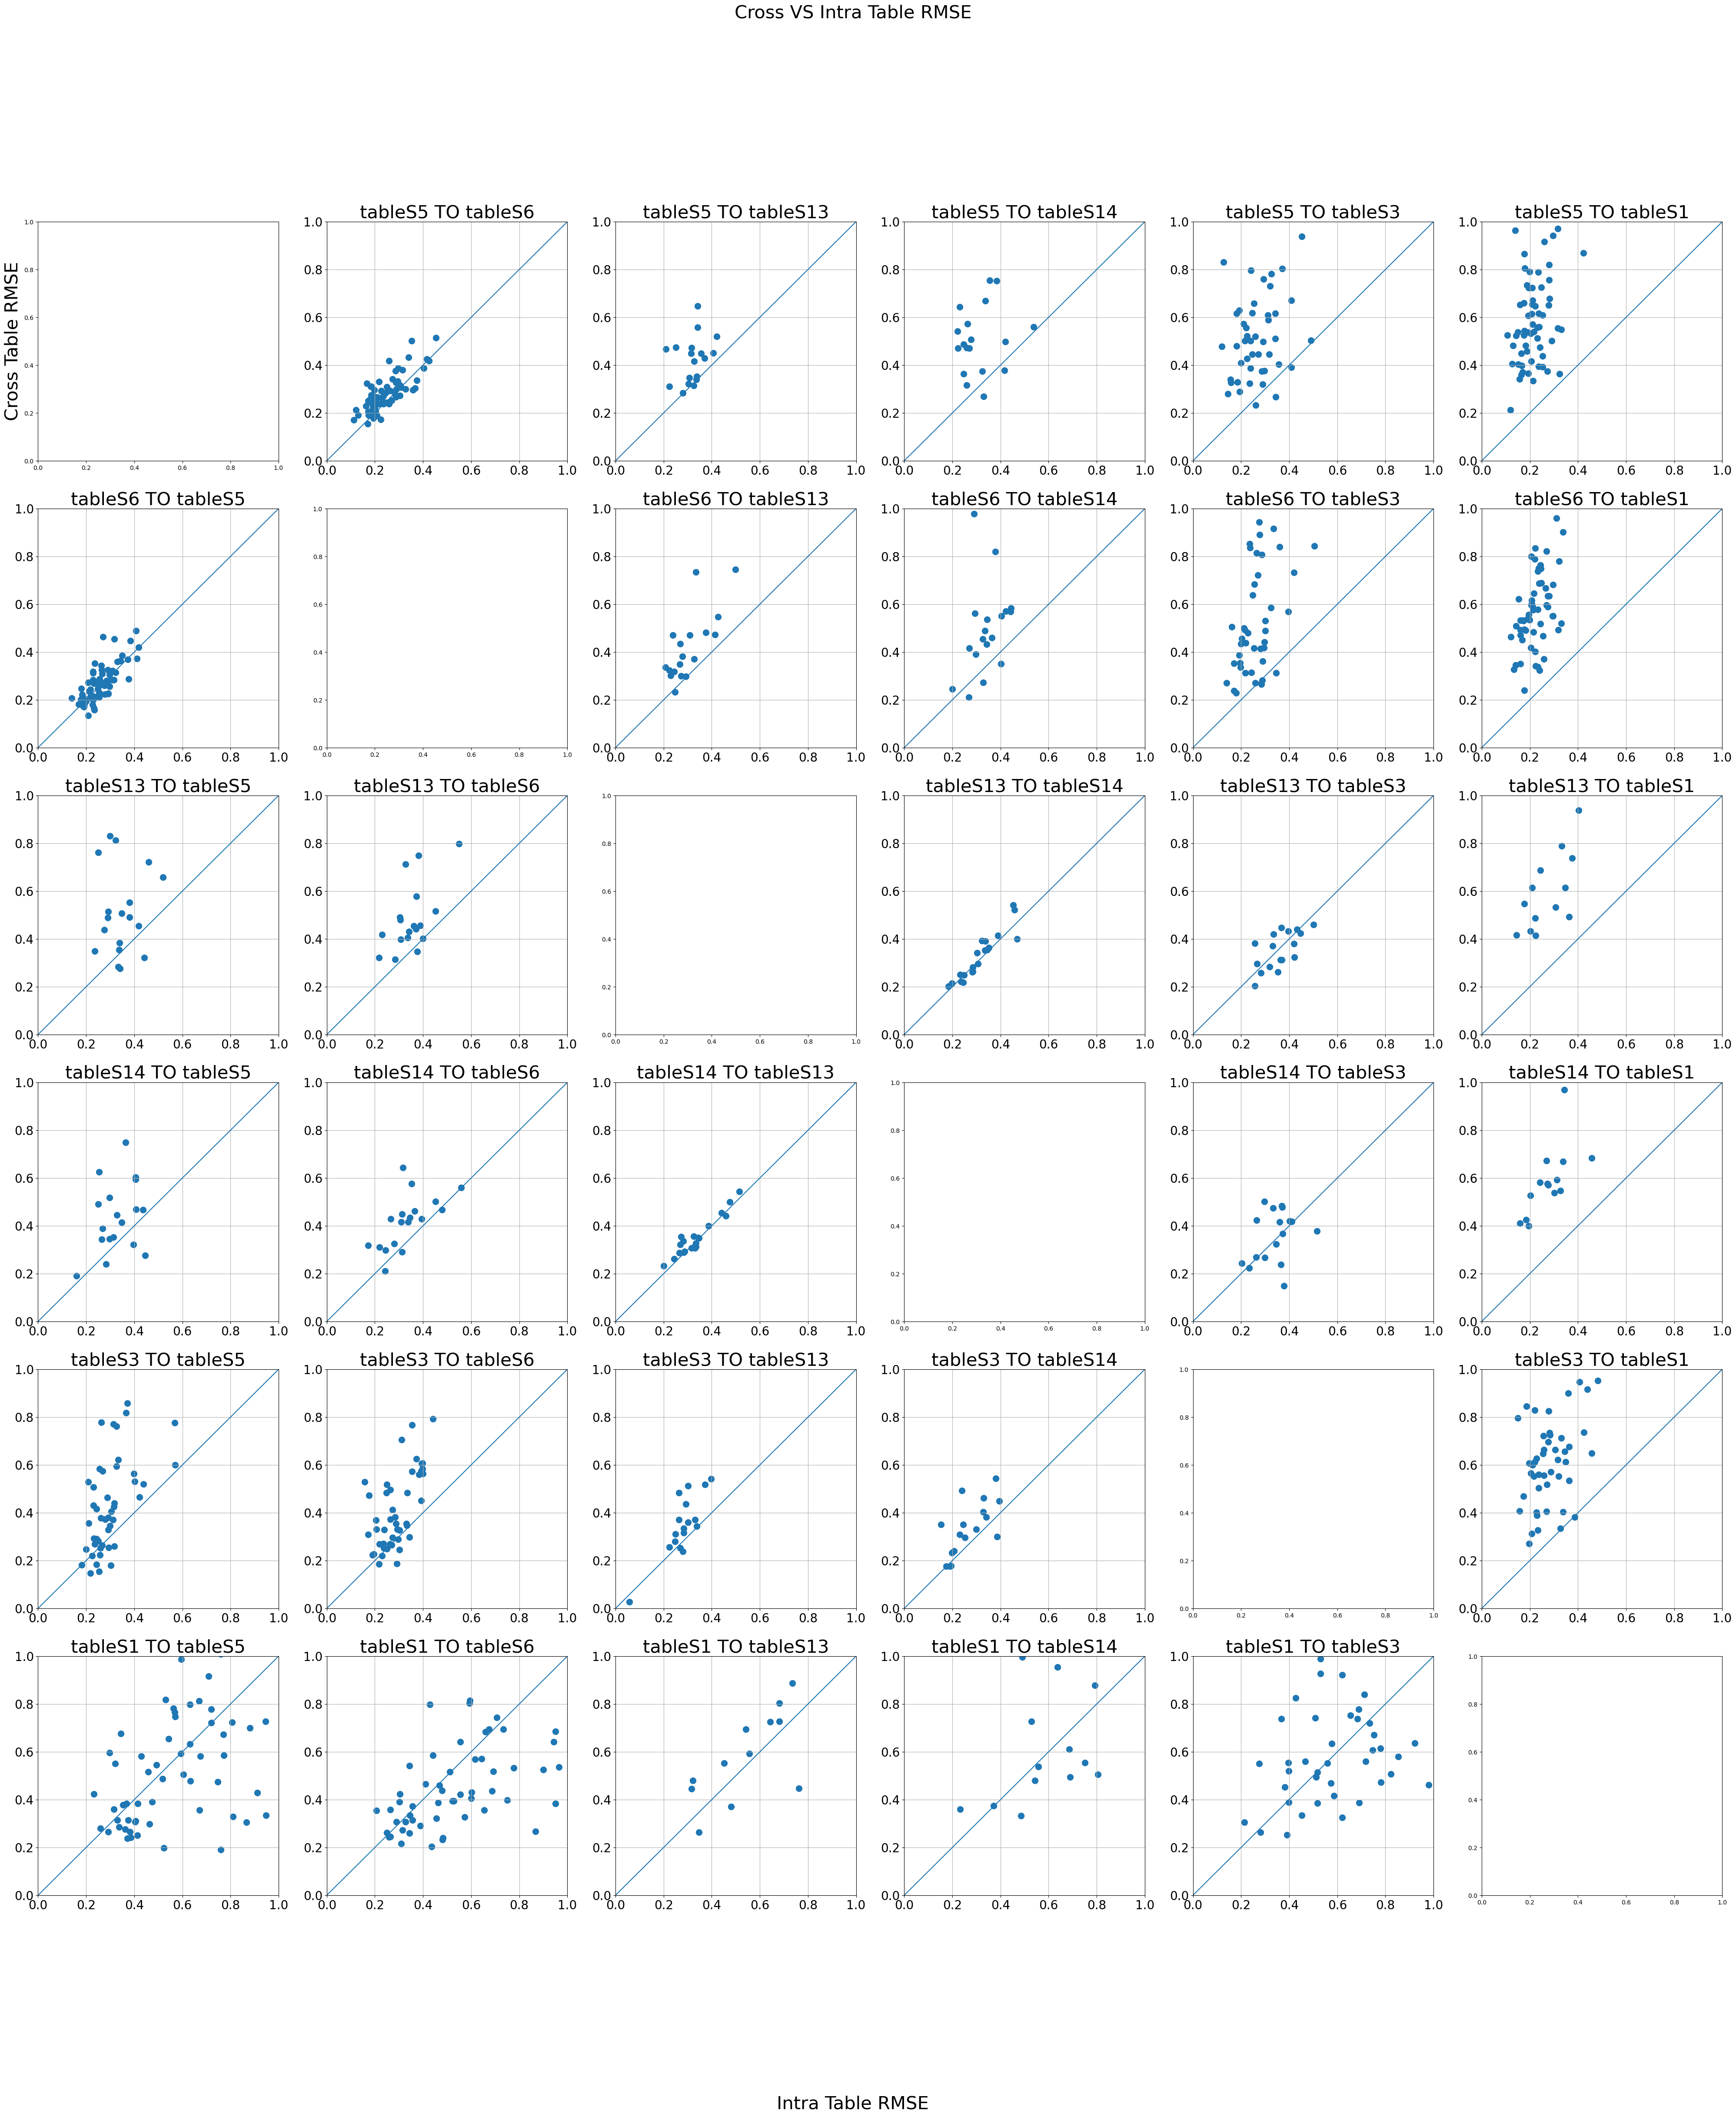

In [274]:
'''
Questions:
- When finding the cross RMSE:
    - Dataset is the whole target dataset, selected on 5 randomly selected feasible viruses
    - If the target virus has all NANs, my cross RMSE is NAN because of RMSE formula.
        - Should I only choose target viruses that have non-NAN values?
'''

nrows, ncols = len(table_names), len(table_names)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 50))

for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            
            x = intra_RMSE_dict[comparison_name]
            y = cross_RMSE_dict[comparison_name]

            axs[idx, jdx].scatter(x,y, s=100)
            axs[idx, jdx].set_title(comparison_name, fontsize = 30)
            axs[0,0].set_ylabel("Cross Table RMSE", fontsize = 30)
            axs[idx, jdx].tick_params(axis='both', which='major', labelsize=20)
            axs[idx, jdx].grid()
            axs[idx, jdx].plot([0, 1], [0, 1], transform=axs[idx, jdx].transAxes)
            axs[idx, jdx].set_xlim([0, 1])
            axs[idx, jdx].set_ylim([0, 1])
        fig.suptitle("Cross VS Intra Table RMSE", fontsize=30)
        fig.supxlabel('Intra Table RMSE', fontsize=30)

In [216]:
tableS1  = data_df.loc[data_df['sera_table']=="TableS1"].drop(['sera_table'], axis=1)
tableS3  = data_df.loc[data_df['sera_table']=="TableS3"].drop(['sera_table'], axis=1)
tableS5  = data_df.loc[data_df['sera_table']=="TableS5"].drop(['sera_table'], axis=1)
tableS6  = data_df.loc[data_df['sera_table']=="TableS6"].drop(['sera_table'], axis=1)
tableS13 = data_df.loc[data_df['sera_table']=="TableS13"].drop(['sera_table'], axis=1)
tableS14 = data_df.loc[data_df['sera_table']=="TableS14"].drop(['sera_table'], axis=1)
table_names = ["tableS1" , "tableS3" , "tableS5" , "tableS6" , "tableS13", "tableS14"]
table_list = [tableS1 , tableS3 , tableS5 , tableS6 , tableS13, tableS14]


target_table = tableS6
source_tables = table_list.copy()
source_tables.pop(2) # source_tables are tables in table_list except for target_table. These are used for training
source_tables = [table_list[3]] # Table S5
feature_targets = list(target_table.columns) # List of viruses to make a tree/prediction on


S6_S5_dict = dict()
for idx, feature_target in enumerate(feature_targets): # Make a tree for each virus in target_table
#     name = f"{feature_target}_tree"
    tree = between_table_trees(
                              target_table=target_table,
                              source_tables=source_tables,
                              selected_viruses_list=False,
                              feature_t=feature_target,
                              )
    if len(tree) != 0:
#         print(idx, feature_target)
        S6_S5_dict[feature_target] = tree
    
    

Text(0.5, 0.01, 'Intra Table RMSE')

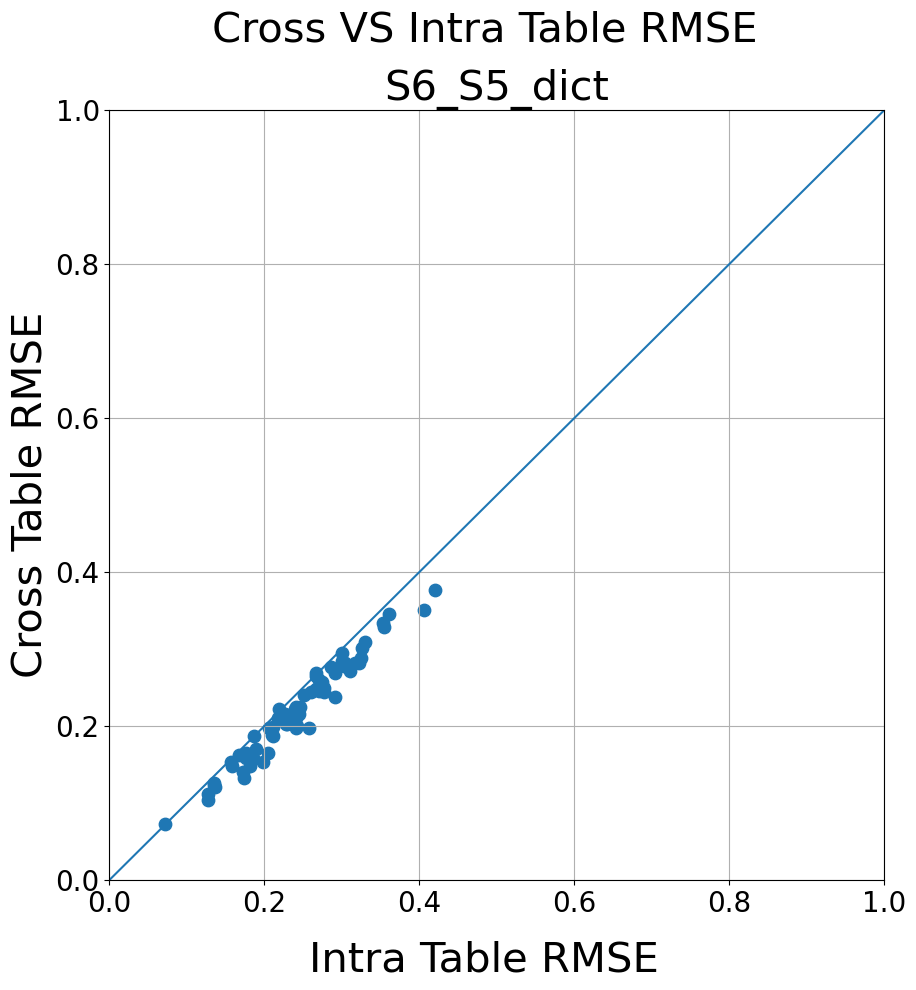

In [217]:
intra_RMSE = []
cross_RMSE = []
for key, val in S6_S5_dict.items():
    intra_RMSE.append(val[f'tree_0_{key}'][1])
    cross_RMSE.append(val[f'tree_0_{key}'][2])
    
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,10),
                        sharex=True, sharey=True,)

x = intra_RMSE
y = cross_RMSE
idx=0
plt.scatter(x,y, s=80)
plt.title('S6_S5_dict', fontsize = 30)
plt.ylabel("Cross Table RMSE", fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid()
plt.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
fig.suptitle("Cross VS Intra Table RMSE", fontsize=30)
fig.supxlabel('Intra Table RMSE', fontsize=30)


In [26]:
intra_RMSE

[0.2995065525536766,
 0.2516060238003161,
 0.22497477359038137,
 0.32043413215974625,
 0.2753405974906647,
 0.2673464033431245,
 0.24800464016851045,
 0.2126502141882793,
 0.2897523406493515,
 0.2726965497881071,
 0.15079417190987107,
 0.24881045649669428,
 0.3474588254035433,
 0.37681089200953904,
 0.2440313700219675,
 0.27164221649652853,
 0.24399752981025646,
 0.2791586566127615,
 0.3389141382582135,
 0.30708056476483403]

In [21]:
S6_S5_dict['A/AUCKLAND/20/2003']['tree_0_A/AUCKLAND/20/2003'][1]

0.2995065525536766

In [10]:
'''
Draw up a boxplot for each tree, covering the RMSEs recorded
by running many times
'''
names = ['S1_S14', 'S3_S14', 'S5_S14', 'S13_S14']
intra_RMSE = {key:[] for key in names}
cross_RMSE = {key:[] for key in names}

tableS1  = data_df.loc[data_df['sera_table']=="TableS1"].drop(['sera_table'], axis=1)
tableS3  = data_df.loc[data_df['sera_table']=="TableS3"].drop(['sera_table'], axis=1)
tableS5  = data_df.loc[data_df['sera_table']=="TableS5"].drop(['sera_table'], axis=1)
tableS6  = data_df.loc[data_df['sera_table']=="TableS6"].drop(['sera_table'], axis=1)
tableS13 = data_df.loc[data_df['sera_table']=="TableS13"].drop(['sera_table'], axis=1)
tableS14 = data_df.loc[data_df['sera_table']=="TableS14"].drop(['sera_table'], axis=1)
table_list = [tableS1 , tableS3 , tableS5 , tableS6 , tableS13, tableS14]
for idx, table in enumerate(table_list): # Iterate over each table, using each current table as the target dataset for predictions
    target_table = table
    source_tables = table_list.copy()
    source_tables.pop(idx) # source_tables are tables in table_list except for target_table. These are used for training
    feature_targets = list(table.columns) # List of viruses to make a tree/prediction on
    for feature_target in feature_targets: # Make a tree for each virus in target_table
        tree = between_table_trees(
                                  target_table=target_table,
                                  source_tables=source_tables,
                                  feature_t=feature_target,
                                  )
        

    S1_to_S14_RMSE  = trees_targeting_S14['tree_0'][1]
    S3_to_S14_RMSE  = trees_targeting_S14['tree_1'][1]
    S5_to_S14_RMSE  = trees_targeting_S14['tree_2'][1]
    S13_to_S14_RMSE = trees_targeting_S14['tree_3'][1]
    intra_RMSE['S1_S14'].append(S1_to_S14_RMSE)
    intra_RMSE['S3_S14'].append(S3_to_S14_RMSE)
    intra_RMSE['S5_S14'].append(S5_to_S14_RMSE)
    intra_RMSE['S13_S14'].append(S13_to_S14_RMSE)
    
    S1_to_S14_cross_RMSE  = trees_targeting_S14['tree_0'][2]
    S3_to_S14_cross_RMSE  = trees_targeting_S14['tree_1'][2]
    S5_to_S14_cross_RMSE  = trees_targeting_S14['tree_2'][2]
    S13_to_S14_cross_RMSE = trees_targeting_S14['tree_3'][2]
    cross_RMSE['S1_S14'].append(S1_to_S14_cross_RMSE)
    cross_RMSE['S3_S14'].append(S3_to_S14_cross_RMSE)
    cross_RMSE['S5_S14'].append(S5_to_S14_cross_RMSE)
    cross_RMSE['S13_S14'].append(S13_to_S14_cross_RMSE)
    

dict_keys(['tree_0', 'tree_1', 'tree_2', 'tree_3'])

# Ensemble Model Using Multiple Training Datasets

In [82]:
'''
Predict A/FUJIAN/140/2000 between
- S5->s14
- S3->s14
- S1->s14
Using random viruses first

The train trees on Ta's virues
'''

feature_t = "A/FUJIAN/140/2000"
# Load whole data and construct feature based on table membership
flu_df = pd.read_csv("../CrossStudyCompletion/Matrix Completion in R/InfluenzaData.csv", sep=',')
sera = flu_df['Measurements (Sera in Rows/Viruses in Columns)'].tolist()
sera_tables = [i[i.index('Table'):] for i in sera]
table_keys = set(sera_tables)
flu_df['sera_table'] = sera_tables
# Construct table dict that assigns entries (vals) to their respective table groups (keys e.g. S5, S13, S14)
flu_table_dict = {table_key: flu_df.loc[flu_df['sera_table']==table_key] for table_key in table_keys}
filtered_flu_table_dict = {key: non_trivialize_df(arg) for key, arg in list(flu_table_dict.items())}
# Index and log scale data
data_df = flu_df.set_index("Measurements (Sera in Rows/Viruses in Columns)")
data_df = data_df.applymap(lambda x: pd.to_numeric(x, errors='coerce') )
data_df = np.log10(data_df)
data_df['sera_table'] = sera_tables # Assign table group to each entry in whole data

# Perform between table analyses
results_dict = dict()
predict_table = 'TableS14'
train_tables = ['TableS5', 'TableS3', 'TableS13']
for train_table in train_tables:
    data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
    data_s = data_df.loc[data_df['sera_table']==train_table].drop(['sera_table'], axis=1)
    data_s_list = [data_s] # single dataframe placed in a list
    # Might wanna store tree models maybe
    results = RF_complete(data_t = data_t,
                      data_s_list=[data_s],
                      feature_t=feature_t)
    title = f'{train_table} to {predict_table}'
    results_dict[title] = results


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce')

1 additional datasets used for prediction.
Feature-of-interest located!
data_assist shape: (212, 81)
Iterating over 81
feature_t check 0 A/AUCKLAND/5/96
feature_t check 0 A/BRISBANE/22/94


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/CHRISTCHURCH/1/96
feature_t check 0 A/FUJIAN/140/2000


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/NEW_YORK/55/2004
feature_t check 0 A/PANAMA/2007/99


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/PERTH/16/2009
feature_t check 0 A/PERTH/27/2007


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/TASMANIA/1/97
feature_t check 0 A/VICTORIA/1/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/VICTORIA/110/2004
feature_t check 0 A/WELLINGTON/96/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 BI/16190/68
feature_t check 0 BI/1761/76


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 BI/2271/76
feature_t check 0 NL/233/82


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 NL/620/89
feature_t check 0 NL/823/92


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 VN016/EL135/2008


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by DecisionTreeRegressor.

In [265]:
# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30,15))
for idx, key in enumerate(list(results_dict.keys())):
    x_data = data_t
    y_data = results_dict[key]['predictions']
    axs[idx].scatter(x_data, y_data, alpha=0.5)
    axs[idx].set_xlabel("log10(HAI Measurements)")
    axs[idx].set_ylabel("log10(Predicted Values)")
    axs[idx].set_title(f"{key} Predicted Error Bars")
    axs[idx].errorbar(data_t[feature_t], y_data,
             yerr=results['errors'], fmt='o', capsize=5, label="Error Bars")
plt.grid(True)
plt.show()

{'TableS5 to TableS14': None,
 'TableS3 to TableS14': None,
 'TableS13 to TableS14': None}

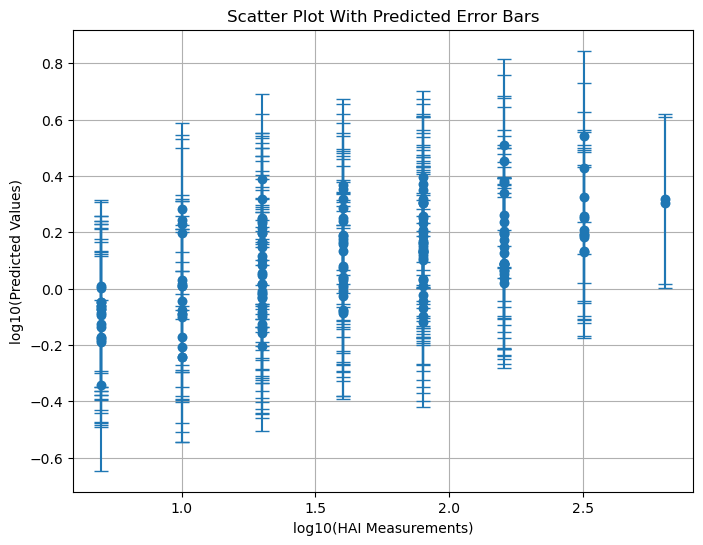

In [88]:
import matplotlib.pyplot as plt

# Assuming 'feature.t' is the feature you want to use as the x-axis
x_data = data_t[feature_t]

# 'out' contains the predictions
y_data = results['predictions']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5)
plt.xlabel("log10(HAI Measurements)")
plt.ylabel("log10(Predicted Values)")
plt.title("Scatter Plot With Predicted Error Bars")
plt.grid(True)


plt.errorbar(data_t[feature_t], y_data,
             yerr=results['errors'], fmt='o', capsize=5, label="Error Bars")

# Actual prediction error (as n-folds)
# actual_error = 10 ** np.sqrt(np.mean((np.log10(y_train) - np.log10(y_pred)) ** 2))
# print("Actual Prediction Error (as n-folds):", actual_error)


plt.show()

In [43]:
data_t
predict_table

'TableS14'

In [44]:
data_df['sera_table'].unique()

array(['TableS1', 'TableS3', 'TableS5', 'TableS6', 'TableS13', 'TableS14'],
      dtype=object)

In [255]:
data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
data_s_list = [
          data_df.loc[data_df['sera_table']=='TableS13'].drop(['sera_table'], axis=1),
          data_df.loc[data_df['sera_table']=='TableS6'].drop(['sera_table'], axis=1),
          data_df.loc[data_df['sera_table']=='TableS5'].drop(['sera_table'], axis=1),
         ]
feature_t = "A/PANAMA/2007/99"

In [256]:
out = RF_complete(data_t, data_s_list, feature_t)

3 additional datasets used for prediction.
Feature-of-interest located!
data_assist shape: (160, 81)
Iterating over 81
feature_t check 0 A/AUCKLAND/5/96
(160, 5)
[0.37189581 0.27945251 0.30832609 0.28013481 0.25027489]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/BRISBANE/22/94


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.30148824 0.3868342  0.33727764 0.32510303 0.24289709]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/CHRISTCHURCH/1/96
(160, 5)
[0.19722312 0.26959122 0.2626321  0.25164877 0.29235242]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/FUJIAN/140/2000


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.18290003 0.30023447 0.30468654 0.26032972 0.17083444]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/NEW_YORK/55/2004
(160, 5)
[0.2061206  0.33917918 0.36581966 0.33852705 0.26597625]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PANAMA/2007/99


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.2619707  0.23342092 0.3206923  0.2826189  0.22569334]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PERTH/16/2009
(160, 5)
[0.33642809 0.3599341  0.4251709  0.36238656 0.32599096]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PERTH/27/2007


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.25717977 0.22541817 0.25063441 0.24828014 0.21323635]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/TASMANIA/1/97
(160, 5)
[0.30169577 0.23368652 0.27326249 0.32507061 0.2839393 ]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/VICTORIA/1/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.34546908 0.30528806 0.31506457 0.3443287  0.24064592]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/VICTORIA/110/2004
(160, 5)
[0.2534038  0.30085886 0.33738022 0.32686624 0.21547095]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/WELLINGTON/96/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.27675124 0.37893046 0.37327065 0.3536926  0.28720152]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/16190/68
(160, 5)
[0.39673988 0.47872003 0.45074884 0.44189103 0.38328329]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/1761/76


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.35992322 0.3384052  0.42626796 0.3532073  0.35320301]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/2271/76
(160, 5)
[0.34636635 0.33113302 0.33199414 0.318432   0.39434973]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/233/82


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.32704597 0.38728541 0.38954316 0.33709826 0.32803941]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/620/89
(160, 5)
[0.29490592 0.40887652 0.41219545 0.41214168 0.30381163]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/823/92


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.47811811 0.35435465 0.36083611 0.34116972 0.29254248]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 VN016/EL135/2008
(160, 5)
[0.27239368 0.28659479 0.27235619 0.23776353 0.22816129]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 VN053/2010


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.21569191 0.29239531 0.23886345 0.28676115 0.28390953]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
Doing lm stuff
['a=0.932', 'b=0.087', 'c=0.047']
feature_t check 0 A/PANAMA/2007/99
(160, 5)
[0.25601147 0.31704404 0.26877067 0.23910276 0.23334919]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
rf_1t1: {'mu': array([0.63733053, 1.27594416, 1.06522317, 1.27575119, 1.23692176,
       1.32217377, 2.10182553, 2.11631957, 1.26590983, 1.41809722,
       1.91794852, 1.18814375, 1.32217377, 0.76275969, 1.91042277,
       1.87298699, 1.85040974, 1.11145277, 2.62528325, 0.90467383,
       1.81194479, 1.63467157, 0.5971932 , 1.87967654, 1.29331128,
       1.94888771, 1.64609956, 1.07860228, 2.00574893, 0.97013591,
       1.29601283, 1.1816931 , 2.19074087, 1.25945919, 1.58096216,
       1.83767385, 1.0752575 , 0.96719545, 1.63698719, 0.7742275 ,
       1.98568027, 1.19296795, 1.16453734, 1.4657603 , 1.87298699,
       1.63698719, 0

/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.43411081 0.56211524 0.3188224  0.33760648 0.47089072]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/BRISBANE/22/94
(160, 5)
[0.40832719 0.51775311 0.27154641 0.46033502 0.26468908]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/CHRISTCHURCH/1/96


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.27322618 0.27347342 0.42534969 0.24108983 0.1895168 ]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/FUJIAN/140/2000
(160, 5)
[0.35252514 0.23328103 0.27452564 0.29140399 0.34192429]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/NEW_YORK/55/2004


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.42778496 0.48402493 0.62624826 0.61873781 0.69699328]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PANAMA/2007/99
(160, 5)
[0.3969614  0.31713483 0.39899758 0.48157634 0.32197523]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PERTH/16/2009


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.4022574  0.34141887 0.41919508 0.3586063  0.33925054]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PERTH/27/2007
(160, 5)
[0.44950054 0.34593451 0.45394178 0.3375619  0.29495334]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/TASMANIA/1/97


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.3969937  0.41491404 0.37316382 0.49835605 0.35985425]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/VICTORIA/1/93
(160, 5)
[0.42473683 0.39217773 0.47728437 0.33729429 0.35552176]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/VICTORIA/110/2004


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.38154949 0.41294759 0.4741922  0.37568557 0.42971972]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/WELLINGTON/96/93
(160, 5)
[0.32964214 0.43884686 0.33963789 0.33826794 0.34910618]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/16190/68


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.50881123 0.46222417 0.67320399 0.69362103 0.55646642]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/1761/76
(160, 5)
[0.40097124 0.52647815 0.57488794 0.44071241 0.40279458]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/2271/76


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.32815612 0.26483292 0.36794763 0.34838084 0.21385822]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/233/82
(160, 5)
[0.48227797 0.71324811 0.46739267 0.52051891 0.43581076]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/620/89


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.4580505  0.29666187 0.2900022  0.4276814  0.38395995]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/823/92
(160, 5)
[0.40419516 0.28979301 0.35614362 0.26459558 0.42846244]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 VN016/EL135/2008


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by DecisionTreeRegressor.